In [1]:
import sys
print(sys.version)

3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [2]:
"""
Created on October 9 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [322]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module_lastOct15_beforeScatterChange
from Zernike_Module_lastOct15_beforeScatterChange import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### 'unit test'

In [7]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  




sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))

allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.07,-0.2,
                                 0.7,1,-0.0,0.00,
                                 0.2,0.1,0.90,
                                 0.1,1,0.28,
                                 50000,20,2.5,0.27,
                                 0.47,1.85,1.0])

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

-5578.30965302


In [140]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

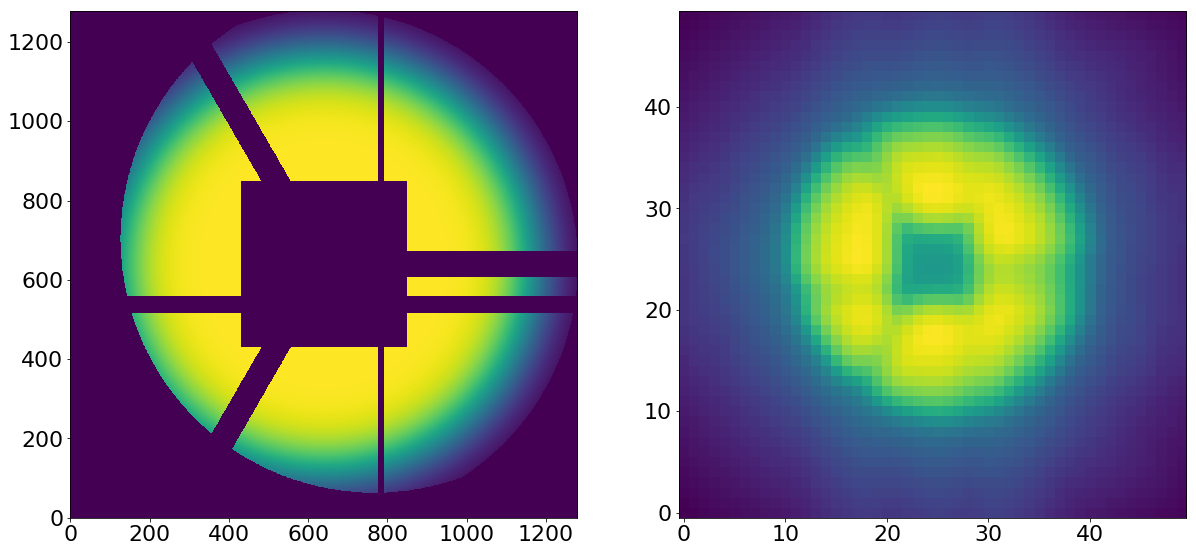

In [141]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Analysis (Single)

## Scripts

In [158]:
#MPI
for single_spot in [2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(single_spot)+'Oct.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 14:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8600,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(single_spot)+'Oct.sh \n')

        
file.close()

In [149]:
#MPI
for single_spot in [0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Oct.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=6 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8600,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI.py "+str(obs)+" "+str(single_spot)+" 75 5\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in [0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]:
    file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(single_spot)+'Oct.sh \n')

        
file.close()

## Focus scripts

In [249]:
print(len(np.array([2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97])))
list_split=np.split(np.array([2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]),20)

40


In [250]:
#MPI
for i in range(20):

    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(i)+'Oct.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
    file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    single_spot=list_split[i][0]
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][1]
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(20):
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(i)+'Oct.sh \n')

        
file.close()

In [251]:
#MPI

list_split=np.split(np.array([0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]),4)

for i in range(4):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/P'+str(1)+'S'+str(single_spot)+'Oct.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=6 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH --time 23:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    single_spot=list_split[i][0]
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][1]
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][2]    
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][3]
    for obs in [8600,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsPerseus'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(4):
    file.write('sbatch /home/ncaplar/Scripts/P'+str(1)+'S'+str(single_spot)+'Oct.sh \n')

        
file.close()

## Focus scripts 2nd round on Oct 16

In [270]:
#MPI
list_split=np.split(np.array([2,22,32,42,52,72,82,92,3,23,33,43,53,73,83,93,4,24,34,44,54,74,84,94,5,25,35,45,55,75,85,95,7,27,37,47,57,77,87,97]),2)



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(1)+'Oct.sh','w') 
file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=4 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 5:59:59 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

file.write("\n")
file.write("#1. Observation (e.g., 8567) \n") 
file.write("#2. Threads \n") 
file.write("#3. Steps \n") 
file.write("\n")

for i in range(20):
    single_spot=list_split[1][i]
    for obs in [8606]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")



file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(2)+'Oct.sh','w') 
file.write("#!/bin/bash \n")
file.write("#SBATCH --nodes=4 # node count \n")
file.write("#SBATCH --ntasks-per-node=40 \n") 
file.write("#SBATCH --time 5:59:59 \n")
file.write("#SBATCH --mail-type=begin  \n")
file.write("#SBATCH --mail-type=end   \n") 
file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")
file.write("#SBATCH --exclude=tiger-h19c1n24 \n") 

file.write("\n")
file.write("#1. Observation (e.g., 8567) \n") 
file.write("#2. Threads \n") 
file.write("#3. Steps \n") 
file.write("\n")

for i in range(20):
    single_spot=list_split[0][i]
    for obs in [8606]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")        

    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(2):
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(i)+'Oct.sh \n')

        
file.close()

In [272]:
#MPI

list_split=np.split(np.array([0,1,8,9,90,91,98,99,6,26,36,46,56,76,86,96]),4)

for i in range(4):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(1)+'S'+str(i)+'Oct.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 5:59:00 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n")

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    single_spot=list_split[i][0]
    for obs in [8606,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][1]
    for obs in [8606,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][2]    
    for obs in [8606,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    single_spot=list_split[i][3]
    for obs in [8606,8600,8603,8573]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Oct_MPI_focus.py "+str(obs)+" "+str(single_spot)+" 75 6\n")
    
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/OctScriptToSubmitScriptsTiger'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for i in range(4):
    file.write('sbatch /home/ncaplar/Scripts/T'+str(1)+'S'+str(i)+'Oct.sh \n')

        
file.close()

## preparation for scripts

### analysis of the test runs

In [164]:
obs='8552'
single_number='82'
image_index=int(single_number)
eps=5
#date='Sep19'
#date='Sep28'
date='Oct5'


obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [165]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 100, 31)
minimal likelihood is: 11921.5290647
minimal chi2 reduced is: 6.61846969492


In [166]:
results_of_fit_many_interpolation=np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct2018/results_of_fit_many_interpolation_preOctoberrun.pkl")
minchain=results_of_fit_many_interpolation['m4'].loc[46].values[:31]

In [167]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

         z4       z5        z6        z7        z8        z9       z10  \
0  27.69776 -0.55644 -0.791879  0.611872 -0.027205 -0.160192 -0.226683   

        z11  
0 -0.733449  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.680592    0.08084  0.050211  0.081485  0.067365      0.18047   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.953455             0.884105  0.036867  0.008806  
   x_fiber  y_fiber  effective_radius_illumination  frd_sigma  det_vert  \
0      0.0      0.0                       0.922886   0.015728  1.039369   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0              0.1425   15952.406394          15.546777          2.349828   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0              0.077712       0.49719  1.907719  0.995147  


In [168]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
minchain[19]=-0.2
model(minchain)
#model(allparameters_proposal)

-312258.61317564035

In [151]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')


optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

In [152]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(122)
plt.imshow(ilum_radiometric,origin='lower')

In [153]:
single_analysis.create_basic_comparison_plot()

chi**2 reduced is: 368.383204517
Abs of residual divided by total flux is: 0.229002194964
Abs of residual divided by largest value of a flux in the image is: 0.276364713548


## Analysis of the defocused data

###  Core Analysis (pandas dataframe creation)

#### Defocus plots 

In [10]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    for var_number in range(len(columns)):
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2    

In [11]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']   

columns_analysis=columns+['chi2','chi2max']

columns_multi=['z4a','z4b','z5a','z5b','z6','z6b','z7a','z7b','z8a','z8b','z9a','z9b','z10a','z10b','z11a','z11b',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
                      'minorAxis','pupilAngle','effective_radius_illumination', 'frd_sigma','det_vert','slitHolder_frac_dx',
                      'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
                      'pixel_effect','fiber_r','flux']  

In [12]:
def create_results_of_fit_single(date,single_number):
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2


            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            
        
        except:
            ValueError
            
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [187]:
def solution_at_0_and_plots(date,single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper):
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=3:
        solution_at_0=np.full(31,0)
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:
            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr_err)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]

            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            if q in columns[:8]:
                # these variables are fit via linear fit, without values at focus
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(index_arr_no0, z4_arr_no0, z4_arr_no0_err_low,z4_arr_no0_err_up))[0]
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[8:21]),np.array(['frd_sigma','det_vert','slitHolder_frac_dx',])),axis=0):
                # these variables are set at mean value (constant fit), without values at focus
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_no0, z4_arr_no0, z4_arr_no0_err_low,z4_arr_no0_err_up))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.array(['grating_lines','scattering_radius','pixel_effect', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######

            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

In [188]:
for i in range(100):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Oct12',i)
    solution_at_0=solution_at_0_and_plots('Oct12',i,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)

0 obs (Emcee3): 8552 is found!
0 obs (Emcee3): 8555 is found!
0 obs (Emcee3): 8558 is found!
0 obs (Emcee3): 8567 is found!
0 obs (Emcee3): 8573 is found!
0 obs (Emcee3): 8600 is found!
0 obs (Emcee3): 8603 is found!
0 obs (Emcee3): 8606 is found!
0 obs (Emcee3): 8612 is found!
0 obs (Emcee3): 8621 is found!
0 obs (Emcee3): 8624 is found!
0 obs (Emcee3): 8627 is found!
1 obs (Emcee3): 8552 is found!
1 obs (Emcee3): 8555 is found!
1 obs (Emcee3): 8558 is found!
1 obs (Emcee3): 8567 is found!
1 obs (Emcee3): 8573 is found!
1 obs (Emcee3): 8600 is found!
1 obs (Emcee3): 8603 is found!
1 obs (Emcee3): 8606 is found!
1 obs (Emcee3): 8612 is found!
1 obs (Emcee3): 8621 is found!
1 obs (Emcee3): 8624 is found!
1 obs (Emcee3): 8627 is found!
2 obs (Emcee3): 8552 is found!
2 obs (Emcee3): 8555 is found!
2 obs (Emcee3): 8558 is found!
2 obs (Emcee3): 8567 is found!
2 obs (Emcee3): 8573 is found!
2 obs (Emcee3): 8600 is found!
2 obs (Emcee3): 8603 is found!
2 obs (Emcee3): 8606 is found!
2 obs (E

37 obs (Emcee3): 8603 is found!
37 obs (Emcee3): 8606 is found!
37 obs (Emcee3): 8612 is found!
37 obs (Emcee3): 8621 is found!
37 obs (Emcee3): 8624 is found!
37 obs (Emcee3): 8627 is found!
42 obs (Emcee3): 8552 is found!
42 obs (Emcee3): 8555 is found!
42 obs (Emcee3): 8558 is found!
42 obs (Emcee3): 8567 is found!
42 obs (Emcee3): 8573 is found!
42 obs (Emcee3): 8600 is found!
42 obs (Emcee3): 8603 is found!
42 obs (Emcee3): 8606 is found!
42 obs (Emcee3): 8612 is found!
42 obs (Emcee3): 8621 is found!
42 obs (Emcee3): 8624 is found!
42 obs (Emcee3): 8627 is found!
43 obs (Emcee3): 8552 is found!
43 obs (Emcee3): 8555 is found!
43 obs (Emcee3): 8558 is found!
43 obs (Emcee3): 8567 is found!
43 obs (Emcee3): 8573 is found!
43 obs (Emcee3): 8600 is found!
43 obs (Emcee3): 8603 is found!
43 obs (Emcee3): 8606 is found!
43 obs (Emcee3): 8612 is found!
43 obs (Emcee3): 8621 is found!
43 obs (Emcee3): 8624 is found!
43 obs (Emcee3): 8627 is found!
44 obs (Emcee3): 8552 is found!
44 obs (

84 obs (Emcee3): 8627 is found!
85 obs (Emcee3): 8552 is found!
85 obs (Emcee3): 8555 is found!
85 obs (Emcee3): 8558 is found!
85 obs (Emcee3): 8567 is found!
85 obs (Emcee3): 8573 is found!
85 obs (Emcee3): 8600 is found!
85 obs (Emcee3): 8603 is found!
85 obs (Emcee3): 8606 is found!
85 obs (Emcee3): 8612 is found!
85 obs (Emcee3): 8621 is found!
85 obs (Emcee3): 8624 is found!
85 obs (Emcee3): 8627 is found!
86 obs (Emcee3): 8552 is found!
86 obs (Emcee3): 8555 is found!
86 obs (Emcee3): 8558 is found!
86 obs (Emcee3): 8567 is found!
86 obs (Emcee3): 8573 is found!
86 obs (Emcee3): 8600 is found!
86 obs (Emcee3): 8603 is found!
86 obs (Emcee3): 8606 is found!
86 obs (Emcee3): 8612 is found!
86 obs (Emcee3): 8621 is found!
86 obs (Emcee3): 8624 is found!
86 obs (Emcee3): 8627 is found!
87 obs (Emcee3): 8552 is found!
87 obs (Emcee3): 8555 is found!
87 obs (Emcee3): 8558 is found!
87 obs (Emcee3): 8567 is found!
87 obs (Emcee3): 8573 is found!
87 obs (Emcee3): 8600 is found!
87 obs (

### Look at the results at one point  - defocused analysis

In [502]:
obs='8552'
single_number='57'
image_index=int(single_number)
eps=5
#date='Sep27'
date='Oct12'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

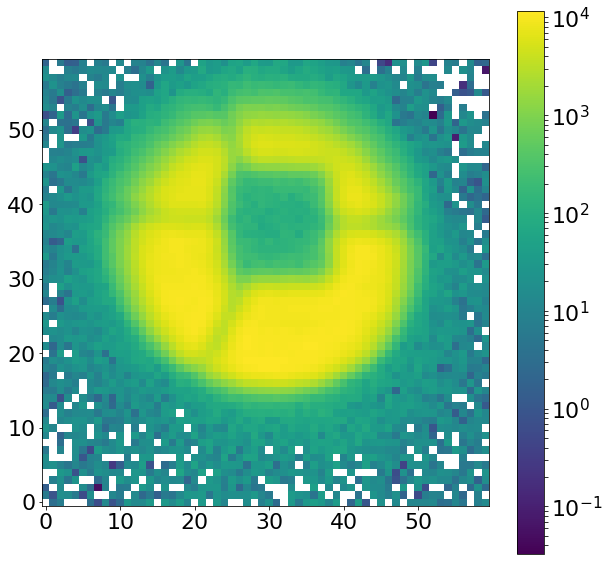

In [503]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [504]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 75, 31)
minimal likelihood is: 19248.1792678
minimal chi2 reduced is: 10.6886094191


In [505]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4        z5        z6        z7        z8        z9       z10  \
0  29.304053 -0.654743 -0.705394  0.626139 -0.192161  0.057327 -0.270874   

        z11  
0 -0.315033  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.661103   0.076599  0.054352  0.227293  0.057674     0.309683   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.653746            -0.499997  0.052593  0.151271  
    x_fiber   y_fiber  effective_ilum_radius  frd_sigma  det_vert  \
0 -0.005672  0.277919               0.864984   0.098477   1.02558   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0            -0.35642   39689.016623          15.777751          2.193991   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0              0.084683      0.425335  1.816648  0.994053  


In [506]:
size=75

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*6+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(6*size+0.5,ls='--')

In [507]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)
#model(allparameters_proposal)

-19248.24411359302

In [508]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')          

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

In [509]:
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(122)
plt.imshow(ilum_radiometric,origin='lower')

In [510]:
single_analysis.create_basic_comparison_plot()

chi**2 reduced is: 10.6886454232
Abs of residual divided by total flux is: 0.0596817476088
Abs of residual divided by largest value of a flux in the image is: 0.119557967933


10.6886454232
chi**2 reduced is: 10.6886454232
Abs of residual divided by total flux is: 0.0596817476088
Abs of residual divided by largest value of a flux in the image is: 0.119557967933


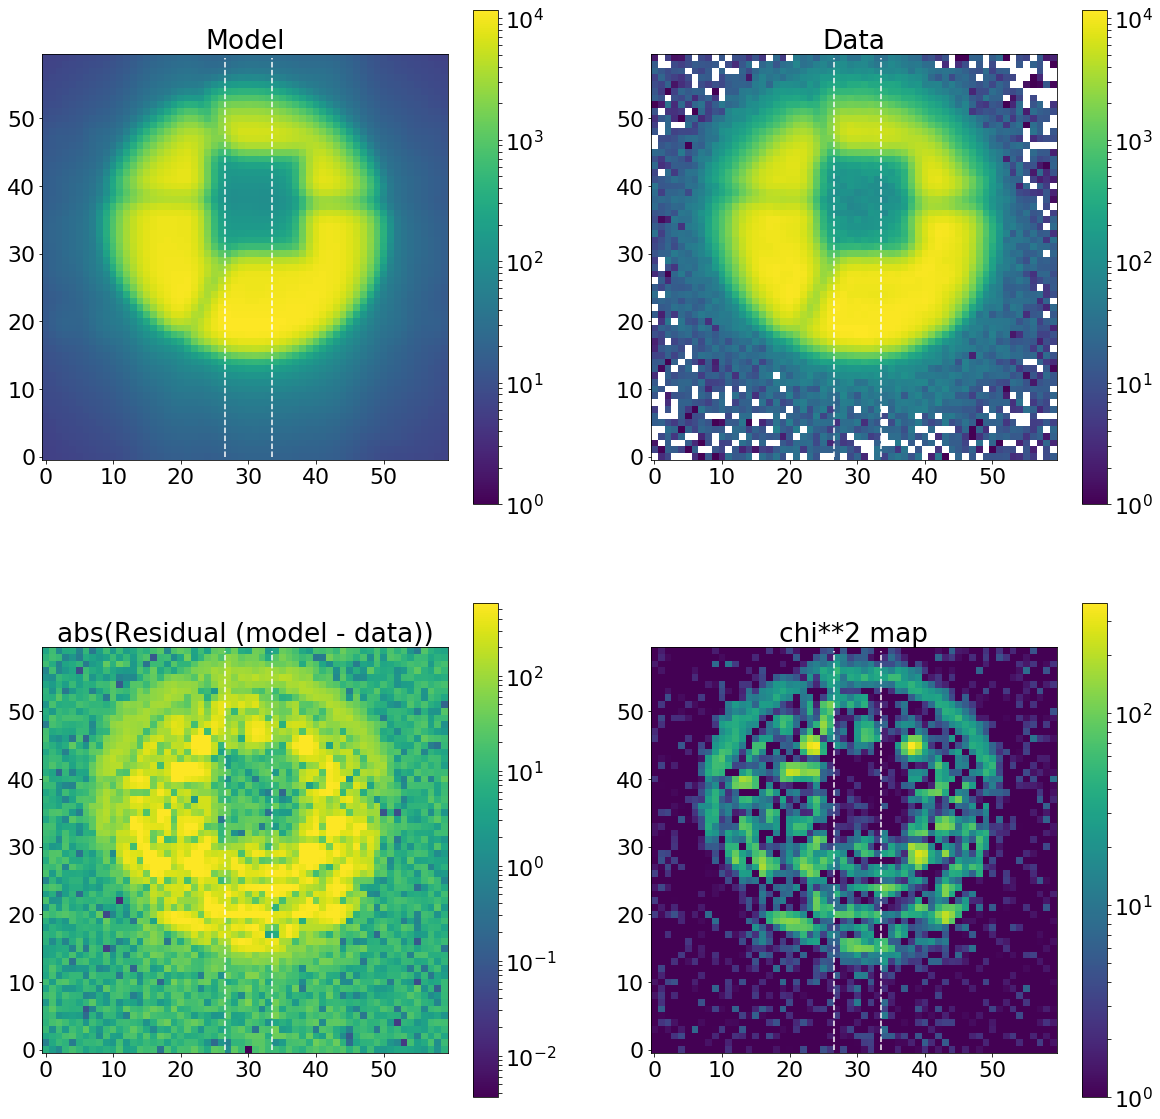

In [511]:
single_analysis.create_basic_comparison_plot_log()

10.6886454232


0.059681747608839368

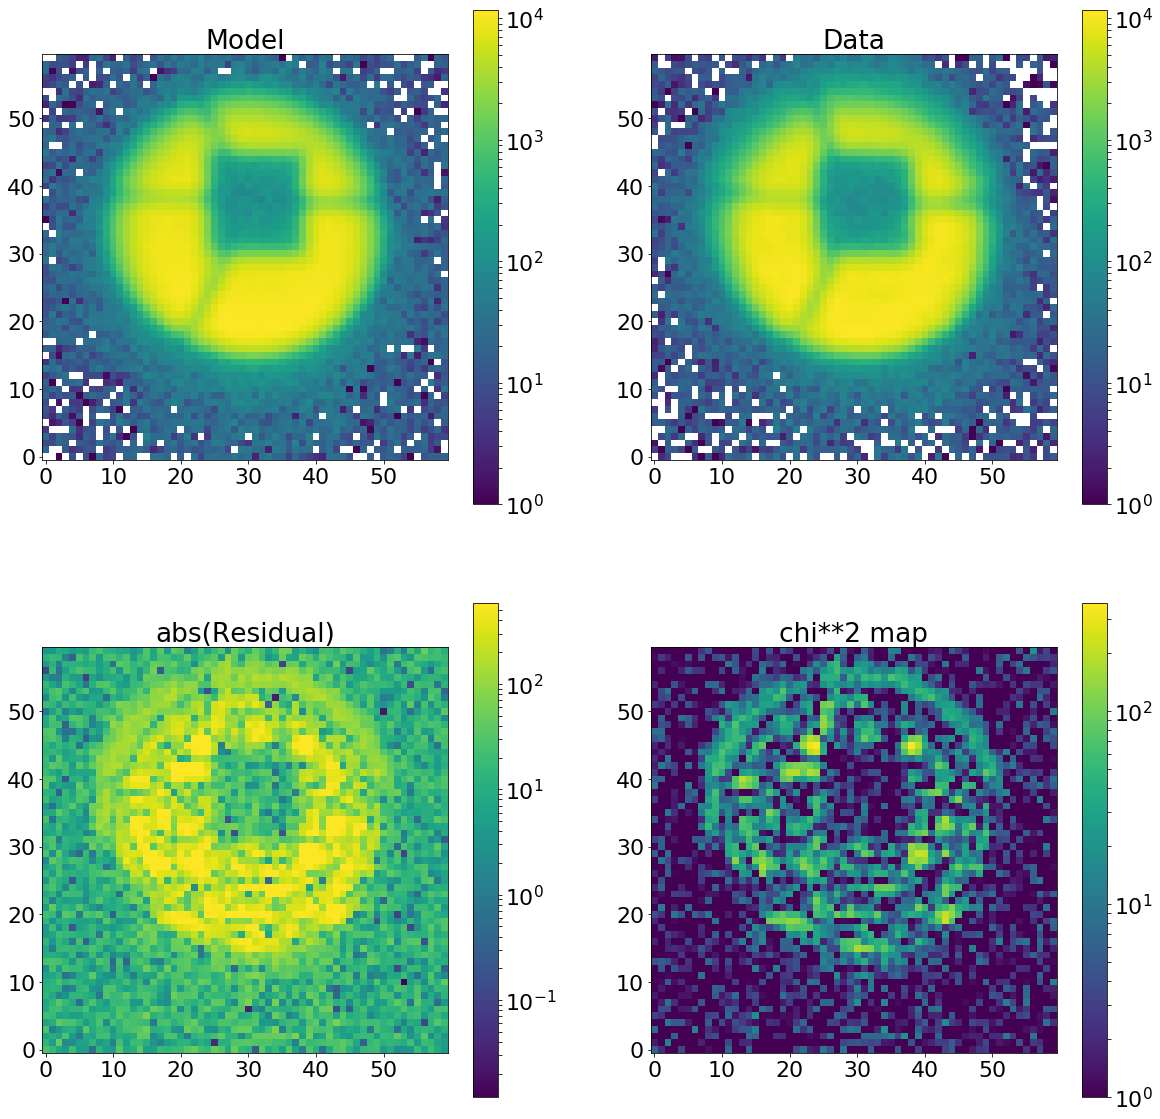

In [512]:
artifical_noise=single_analysis.create_artificial_noise()
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

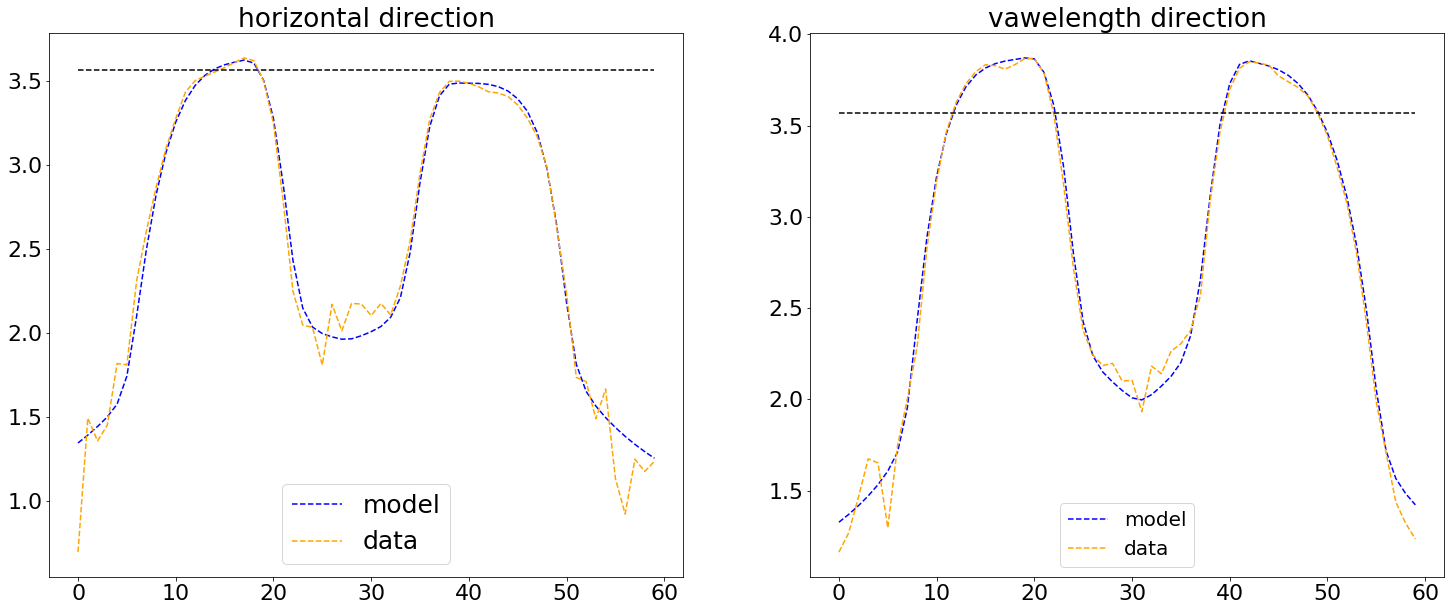

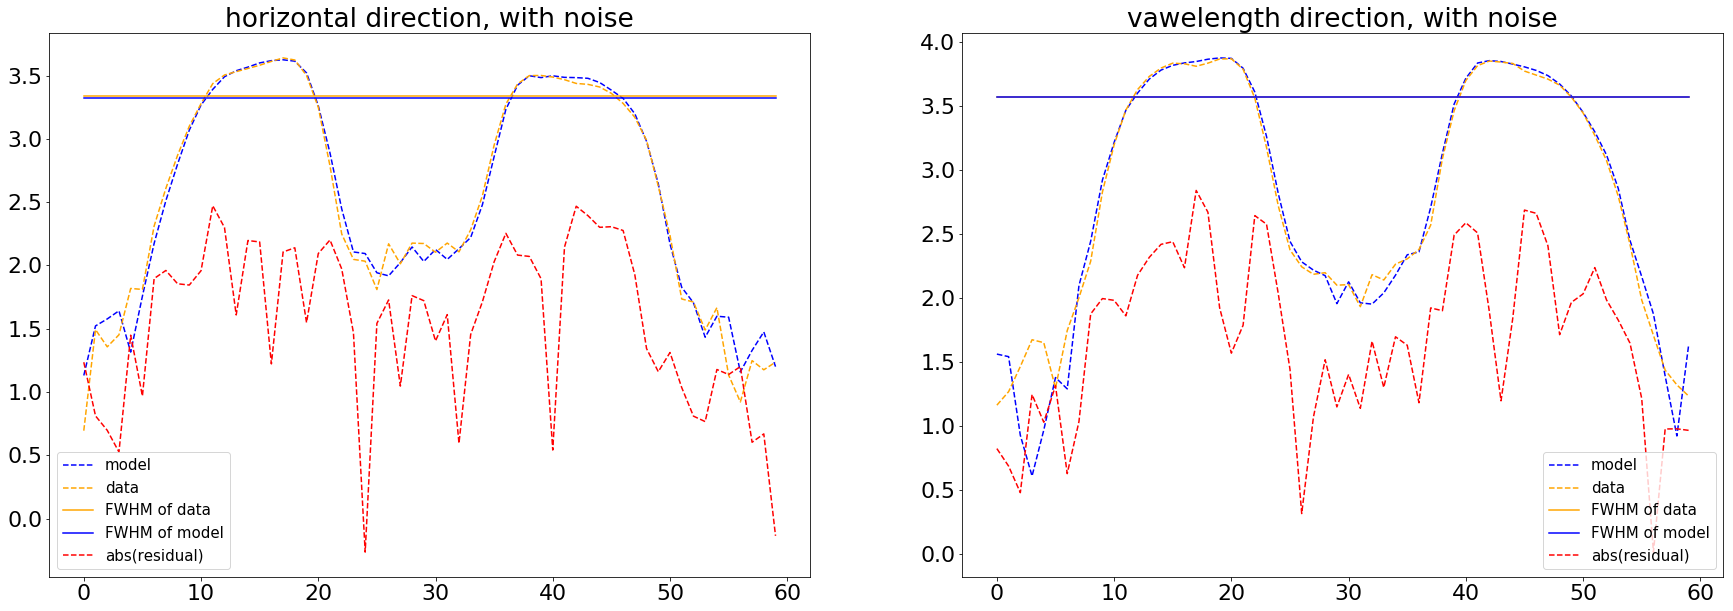

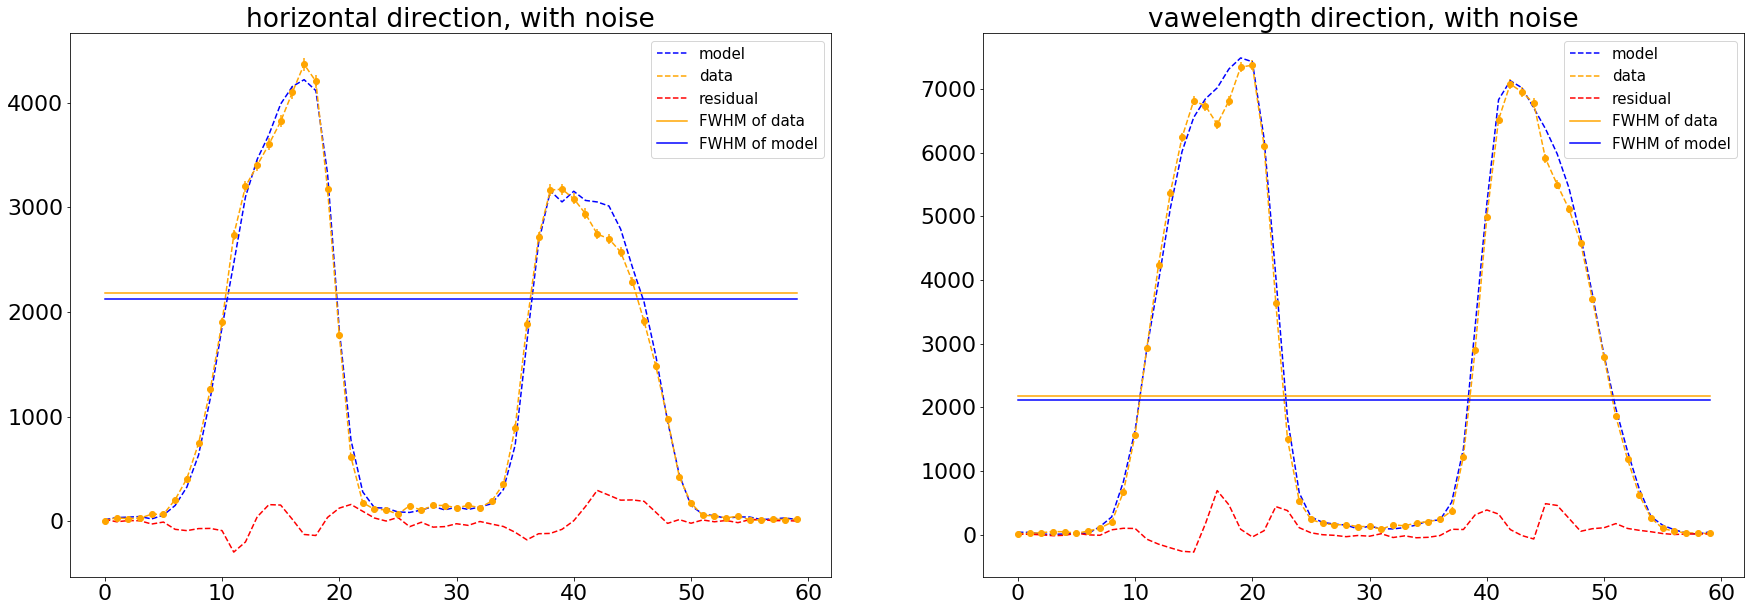

In [501]:
single_analysis.create_cut_plots()

## Preparation for focused data (total solution)

### creation of results_of_fit_many

In [13]:
def solution_at_0_and_plots(date,single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper):
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=3:
        solution_at_0=np.full(31,0)
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:
            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr_err)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]

            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            if q in columns[:8]:
                # these variables are fit via linear fit, without values at focus
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(index_arr_no0, z4_arr_no0, z4_arr_no0_err_low,z4_arr_no0_err_up))[0]
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[8:21]),np.array(['frd_sigma','det_vert','slitHolder_frac_dx',])),axis=0):
                # these variables are set at mean value (constant fit), without values at focus
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_no0, z4_arr_no0, z4_arr_no0_err_low,z4_arr_no0_err_up))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.array(['grating_lines','scattering_radius','pixel_effect', 'scattering_slope', 'scattering_amplitude','fiber_r','flux','chi2','chi2max']):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######
            """
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(single_number))

            plt.close()   
            """
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

In [14]:
single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_ilum_radius','frd_sigma','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']  

columns_analysis=columns+['chi2','chi2max']

results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)
err_results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)

results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_many_single_defocus)
err_results_of_fit_many_single_defocus_pd=pd.DataFrame(err_results_of_fit_many_single_defocus)

results_of_fit_many = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(100):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Oct12',single_number)
    solution_at_0=solution_at_0_and_plots('Oct12',single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many[label[i]]=results_of_fit_many[label[i]][np.abs(results_of_fit_many[label[i]]['z4'])>0]

0 obs (Emcee3): 8552 is found!
0 obs (Emcee3): 8555 is found!
0 obs (Emcee3): 8558 is found!
0 obs (Emcee3): 8567 is found!
0 obs (Emcee3): 8573 is found!
0 obs (Emcee3): 8600 is found!
0 obs (Emcee3): 8603 is found!
0 obs (Emcee3): 8606 is found!
0 obs (Emcee3): 8612 is found!
0 obs (Emcee3): 8621 is found!
0 obs (Emcee3): 8624 is found!
0 obs (Emcee3): 8627 is found!
1 obs (Emcee3): 8552 is found!
1 obs (Emcee3): 8555 is found!
1 obs (Emcee3): 8558 is found!
1 obs (Emcee3): 8567 is found!
1 obs (Emcee3): 8573 is found!
1 obs (Emcee3): 8600 is found!
1 obs (Emcee3): 8603 is found!
1 obs (Emcee3): 8606 is found!
1 obs (Emcee3): 8612 is found!
1 obs (Emcee3): 8621 is found!
1 obs (Emcee3): 8624 is found!
1 obs (Emcee3): 8627 is found!
2 obs (Emcee3): 8552 is found!
2 obs (Emcee3): 8555 is found!
2 obs (Emcee3): 8558 is found!
2 obs (Emcee3): 8567 is found!
2 obs (Emcee3): 8573 is found!
2 obs (Emcee3): 8600 is found!
2 obs (Emcee3): 8603 is found!
2 obs (Emcee3): 8606 is found!
2 obs (E

37 obs (Emcee3): 8603 is found!
37 obs (Emcee3): 8606 is found!
37 obs (Emcee3): 8612 is found!
37 obs (Emcee3): 8621 is found!
37 obs (Emcee3): 8624 is found!
37 obs (Emcee3): 8627 is found!
42 obs (Emcee3): 8552 is found!
42 obs (Emcee3): 8555 is found!
42 obs (Emcee3): 8558 is found!
42 obs (Emcee3): 8567 is found!
42 obs (Emcee3): 8573 is found!
42 obs (Emcee3): 8600 is found!
42 obs (Emcee3): 8603 is found!
42 obs (Emcee3): 8606 is found!
42 obs (Emcee3): 8612 is found!
42 obs (Emcee3): 8621 is found!
42 obs (Emcee3): 8624 is found!
42 obs (Emcee3): 8627 is found!
43 obs (Emcee3): 8552 is found!
43 obs (Emcee3): 8555 is found!
43 obs (Emcee3): 8558 is found!
43 obs (Emcee3): 8567 is found!
43 obs (Emcee3): 8573 is found!
43 obs (Emcee3): 8600 is found!
43 obs (Emcee3): 8603 is found!
43 obs (Emcee3): 8606 is found!
43 obs (Emcee3): 8612 is found!
43 obs (Emcee3): 8621 is found!
43 obs (Emcee3): 8624 is found!
43 obs (Emcee3): 8627 is found!
44 obs (Emcee3): 8552 is found!
44 obs (

84 obs (Emcee3): 8627 is found!
85 obs (Emcee3): 8552 is found!
85 obs (Emcee3): 8555 is found!
85 obs (Emcee3): 8558 is found!
85 obs (Emcee3): 8567 is found!
85 obs (Emcee3): 8573 is found!
85 obs (Emcee3): 8600 is found!
85 obs (Emcee3): 8603 is found!
85 obs (Emcee3): 8606 is found!
85 obs (Emcee3): 8612 is found!
85 obs (Emcee3): 8621 is found!
85 obs (Emcee3): 8624 is found!
85 obs (Emcee3): 8627 is found!
86 obs (Emcee3): 8552 is found!
86 obs (Emcee3): 8555 is found!
86 obs (Emcee3): 8558 is found!
86 obs (Emcee3): 8567 is found!
86 obs (Emcee3): 8573 is found!
86 obs (Emcee3): 8600 is found!
86 obs (Emcee3): 8603 is found!
86 obs (Emcee3): 8606 is found!
86 obs (Emcee3): 8612 is found!
86 obs (Emcee3): 8621 is found!
86 obs (Emcee3): 8624 is found!
86 obs (Emcee3): 8627 is found!
87 obs (Emcee3): 8552 is found!
87 obs (Emcee3): 8555 is found!
87 obs (Emcee3): 8558 is found!
87 obs (Emcee3): 8567 is found!
87 obs (Emcee3): 8573 is found!
87 obs (Emcee3): 8600 is found!
87 obs (

In [15]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many,f, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Oct12'
descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,9,10,16,17,18]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|                                                                   | 0/9 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/hscFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/strutFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/dxFocal/
Images are in folder: /Users/nevencaplar/Docu

 11%|██████▌                                                    | 1/9 [00:15<02:04, 15.52s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/m35/


 22%|█████████████                                              | 2/9 [00:30<01:45, 15.07s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/m3/


 33%|███████████████████▋                                       | 3/9 [00:44<01:28, 14.72s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/m05/


 44%|██████████████████████████▏                                | 4/9 [00:58<01:12, 14.51s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/0/


 56%|████████████████████████████████▊                          | 5/9 [01:11<00:57, 14.36s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/p05/


 67%|███████████████████████████████████████▎                   | 6/9 [01:25<00:42, 14.25s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/p35/


 78%|█████████████████████████████████████████████▉             | 7/9 [01:39<00:28, 14.23s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/p4/


 89%|████████████████████████████████████████████████████▍      | 8/9 [01:53<00:14, 14.21s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct12/Plane/0p/


100%|███████████████████████████████████████████████████████████| 9/9 [02:07<00:00, 14.16s/it]


### 1D plots

In [18]:
res_y=[]
for i in [5,25,35,45,55,75,85,95]:
    res_y.append(4294-single_number_for_single_pos_full[i][4])
res_y=np.array(res_y)

In [19]:
res_x=[]
for i in [40,41,42,43,44,45,46,47,48,49]:
    res_x.append(single_number_for_single_pos_full[i][3])
res_x=np.array(res_x)

In [117]:
res_x[res_x>int(4096/2)]=res_x[res_x>int(4096/2)]+69

In [119]:
loc_w=[[2,3,4,5,6,7],[22,23,24,25,26,27],[32,33,34,35,36,37],[42,43,44,45,46,47],[52,53,54,55,56,57],[72,73,74,75,76,77],[82,83,84,85,86,87],[92,93,94,95,96,97]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
 
description='hscFrac'

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7]:
        res0.append(np.median(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7]:
        res1.append(np.median(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7]:
        res2.append(np.median(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7]:
        res3.append(np.median(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7]:
        res4.append(np.median(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7]:
        res5.append(np.median(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7]:
        res6.append(np.median(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7]:
        res7.append(np.median(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7]:
        res8.append(np.median(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    res_defocused=np.array([res0,res1,res2,res6,res7,res8])
    #res_y_defocused=res_y[0,1,2,6,7,8]
    res_focused=np.array([res3,res4,res5])
        
    res_defocused_median=[]
    for i in range(res_defocused.shape[1]):
        x=res_defocused[:,i]
        x=x[~np.isnan(x)]
        res_defocused_median.append(np.median(x))
        
    popt, pcov = curve_fit(lin_fit_1DConstant, res_y, res_defocused_median)
        
    plt.figure(figsize=(30,12))
    plt.plot(res_y,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_y,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_y,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.plot(res_y,np.ones(len(res_y))*popt,label='def median',color='black',lw=3,marker='o',markersize=15,ls=':')
    plt.title('y: '+str(description))

    plt.legend()  

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'y'+str(description))
    plt.close()

In [120]:
loc_w=[[0,20,30,40,50,60,70,80,90],[1,21,31,41,51,61,71,81,91],[2,22,32,42,52,62,72,82,92],[3,23,33,43,53,63,73,83,93],[4,24,34,44,54,64,74,84,94],[5,25,35,45,55,65,75,85,95],
       [6,26,36,46,56,66,76,86,96],[7,27,37,47,57,67,87,97],[8,28,38,48,58,68,78,88,98],[9,29,39,49,59,69,79,89,99]]
label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']

for description in columns:

    res0=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res0.append(np.mean(results_of_fit_many[label_short[0]].loc[loc_w[w]][description].dropna(how='all')))

    res1=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res1.append(np.mean(results_of_fit_many[label_short[1]].loc[loc_w[w]][description].dropna(how='all')))

    res2=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res2.append(np.mean(results_of_fit_many[label_short[2]].loc[loc_w[w]][description].dropna(how='all')))

    res3=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res3.append(np.mean(results_of_fit_many[label_short[3]].loc[loc_w[w]][description].dropna(how='all')))

    res4=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res4.append(np.mean(results_of_fit_many[label_short[4]].loc[loc_w[w]][description].dropna(how='all')))

    res5=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res5.append(np.mean(results_of_fit_many[label_short[5]].loc[loc_w[w]][description].dropna(how='all')))

    res6=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res6.append(np.mean(results_of_fit_many[label_short[6]].loc[loc_w[w]][description].dropna(how='all')))

    res7=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res7.append(np.mean(results_of_fit_many[label_short[7]].loc[loc_w[w]][description].dropna(how='all')))

    res8=[]
    for w in [0,1,2,3,4,5,6,7,8,9]:
        res8.append(np.mean(results_of_fit_many[label_short[8]].loc[loc_w[w]][description].dropna(how='all')))

    plt.figure(figsize=(30,12))
    plt.plot(res_x,res0,label='m4',color='red',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res1,label='m35',color='orange',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res2,label='m3',color='yellow',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res3,label='m05',color='brown',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res4,label='0',color='black',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res5,label='p05',color='violet',lw=3,marker='o',markersize=15,ls='--')
    plt.plot(res_x,res6,label='p3',color='magenta',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res7,label='p35',color='cyan',lw=3,marker='o',markersize=15)
    plt.plot(res_x,res8,label='p3',color='blue',lw=3,marker='o',markersize=15)
    plt.title('x: '+str(description))

    plt.legend()
    
    

    IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/1D/'

    if not os.path.exists(IMAGES_FOLDER2):
        os.makedirs(IMAGES_FOLDER2)
        print('Images are in folder: '+str(IMAGES_FOLDER2))

    plt.savefig(IMAGES_FOLDER2+'x'+str(description))
    plt.close()
    

### Creation of prediction for next fit and verification

In [203]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [204]:
results_of_fit_many_interpolation = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}

In [205]:
i=0
all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation[label[i]].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation[label[i]].index.astype(int)][:,4]

In [206]:
all_x[all_x>int(4096/2)]=all_x[all_x>int(4096/2)]+69

all_x_in_respect_to_center=all_x-int((4096+69)/2)
all_y_in_respect_to_center=all_y-int(4176/2)

In [207]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_ilum_radius','frd_sigma','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']  

In [208]:
# parameters that vary slowly across the detector - describing wavefront and pupil (without illumination of the pupil)

single_parameter=[]
for j in ['z4','z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx']:
    for i in label_defocus:
        single_selection=results_of_fit_many[i][j]
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]), ydata=single_parameter[:,4],p0=[0,0,0,0,0,0,0,0,0])
    print(str(j)+' '+str(popt))
    print(str(j)+' '+str(func([2100,0,mm[label.index(i)]],*popt)))


    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),mm[label.index(i)])],*popt)

z4 [-0.000006    0.00000024 -0.00010225  0.00000015 -7.61995088 -1.00804073
  0.00000005 -0.00001317  0.00007708]
z4 -30.540089113
z5 [ 0.00002076  0.00000007 -0.00007841 -0.00000001  0.01257    -0.23661718
  0.00000026  0.00020785 -0.00001281]
z5 1.92235968481
z6 [ 0.00001076  0.00000013 -0.00005542 -0.00000024  0.19275922 -0.14074264
 -0.00000002  0.00000364 -0.00009011]
z6 1.2529477951
z7 [ 0.00011376 -0.00000003 -0.00010435 -0.00000004 -0.01820188  0.54607933
  0.00000007 -0.00000031 -0.00001557]
z7 0.561884212608
z8 [-0.00022381 -0.          0.00000242  0.00000003 -0.0347839  -0.05561376
  0.00000001  0.00003479 -0.00001217]
z8 -0.380226862915
z9 [ 0.0000348   0.00000002 -0.00004312 -0.00000002  0.00113774 -0.16370656
 -0.          0.0000023  -0.00000293]
z9 0.00815687060959
z10 [ 0.00002769 -0.          0.00001455 -0.00000001 -0.00498591 -0.2819536
 -0.00000003  0.00002632 -0.00000123]
z10 -0.0313669799928
z11 [-0.00001499  0.00000008 -0.00008186  0.00000008  0.03530277 -0.436711

In [209]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['frd_sigma','radiometricEffect','radiometricExponent','x_ilum','y_ilum','x_fiber','y_fiber','effective_ilum_radius']:
    dx=[]
    values=[]
    for i in label_defocus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dspot==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=values




In [223]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_radius','scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection=results_of_fit_many[i][j]
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]), single_parameter[:,4])
        #print(popt)


    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),mm[label.index(i)])],*popt)

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [224]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for 2 value in focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)
                                           
dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,2]

    values=[]
    for l in range(100):
        values.append(grating_lines_res[int(single_number_for_single_pos_full[l][2])])
        
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation[i].at[:,j]=values


In [225]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all focused measurments?
inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dx=[]
    values=[]
    for i in label_focus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dspot==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation[i].at[:,j]=values

In [226]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation,f, protocol=pickle.HIGHEST_PROTOCOL)

#### verification 

In [227]:
from shutil import copy

In [234]:
columns[15]

'radiometricExponent'

In [235]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,5,7,8,9,10,12,16,17]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,8,9,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            
        if np.in1d([i],[18,19])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+max_dif
            min_colors=median_color-max_dif            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Interpolation: '+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        #copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]), IMAGES_FOLDER2)
        
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|█████████████████████████████████████████████████████████| 11/11 [02:52<00:00, 15.67s/it]


In [236]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

descriptions=results_of_fit_many[label[0]].columns
for j in tqdm([0,1,2,7,9,10,16,17,18]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many[label[j]][descriptions[i]])
        values_residuals=np.array(results_of_fit_many_interpolation[label[j]][descriptions[i]])[np.array(results_of_fit_many[label[j]][descriptions[i]].index).astype(int)]
        
        colors=values-values_residuals
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,8,9,12,13,14,15,16,17,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            
        if np.in1d([i],[18,19])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+max_dif
            min_colors=median_color-max_dif   
            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title("Residuals: "+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResidual/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResidual/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i])+'.png', IMAGES_FOLDER2)
        
        
        #plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|███████████████████████████████████████████████████████████| 9/9 [01:32<00:00, 10.30s/it]


## Analysis of the focused data

### Core Analysis (pandas dataframe creation)  (no defocus plots)


In [260]:
def create_results_of_fit_single(date,single_number):
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=[8552,8555,8558,8561,8564,8567,8570,8573,8600,8603,8606,8609,8612,8615,8618,8621,8624,8627]

    #single_number=55
    image_index=single_number
    method='P'
    eps=6

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned_Dithered.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked_Dithered.npy')
            else:       
                sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(image_index)+'Stacked_Cleaned.npy')
                var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(image_index)+'Stacked.npy')

            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2


            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            
        
        except:
            ValueError
            
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [252]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)
    
single_number_for_single_pos_full\
=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

In [255]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_radius_illumination','frd_sigma','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']      

columns_analysis=columns+['chi2','chi2max']

results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)
err_results_of_fit_many_single_defocus=pd.DataFrame(np.zeros((len(single_number_for_single_pos_full[:,0]),len(columns_analysis))).reshape(-1,len(columns_analysis)),index=single_number_for_single_pos_full[:,0],columns=columns_analysis)

results_of_fit_many_single_defocus_pd=pd.DataFrame(results_of_fit_many_single_defocus)
err_results_of_fit_many_single_defocus_pd=pd.DataFrame(err_results_of_fit_many_single_defocus)

results_of_fit_many_focus = {'m4': results_of_fit_many_single_defocus_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_pd.copy(),
                       '0d' : results_of_fit_many_single_defocus_pd.copy(),
                       '0' :  results_of_fit_many_single_defocus_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_pd.copy()}


In [261]:
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(100):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Oct10',single_number)
    #solution_at_0=solution_at_0_and_plots('Sep27',single_number,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_focus[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_focus[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:        
    results_of_fit_many_focus[label[i]]=results_of_fit_many_focus[label[i]][np.abs(results_of_fit_many_focus[label[i]]['z4'])>0]

2 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
2 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: f

z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
5 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
s

23 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
24 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac:

effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
32 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
32 obs (Emcee3): 8600 

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
35 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFo

x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
43 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_

52 obs (Emcee3): 8573 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
52 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac:

hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
55 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
73 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFo

x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
77 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
de

z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
85 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!


93 obs (Emcee3): 8600 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
93 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac:

z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
97 obs (Emcee3): 8603 is found!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFocal: failed!
dyFocal: failed!
slitFrac: failed!
slitFrac_dy: failed!
radiometricEffect: failed!
radiometricExponent: failed!
x_ilum: failed!
y_ilum: failed!
x_fiber: failed!
y_fiber: failed!
effective_radius_illumination: failed!
frd_sigma: failed!
det_vert: failed!
slitHolder_frac_dx: failed!
z5: failed!
z6: failed!
z7: failed!
z8: failed!
z9: failed!
z10: failed!
z11: failed!
hscFrac: failed!
strutFrac: failed!
dxFo

In [263]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_focus.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_focus,f, protocol=pickle.HIGHEST_PROTOCOL)

### Plane plots

In [264]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Oct10'


descriptions=results_of_fit_many_focus[label[0]].columns
for j in tqdm([9,8,7,10]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_focus[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_focus[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_focus[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        copy(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i])+'.png', IMAGES_FOLDER2)
        plt.clf()

  0%|                                                                   | 0/4 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/0/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/hscFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/strutFrac/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/dxFocal/
Images are in folder: /Users/nevencaplar/Docum

 25%|██████████████▊                                            | 1/4 [00:11<00:35, 11.75s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/0d/


 50%|█████████████████████████████▌                             | 2/4 [00:22<00:22, 11.35s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Oct10/Plane/m05/


 75%|████████████████████████████████████████████▎              | 3/4 [00:33<00:11, 11.18s/it]/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


ValueError: max() arg is an empty sequence

## Look at result of the analysis at one single point - focus analysis

In [293]:
obs='8603'
single_number='25'
image_index=int(single_number)
eps=6
#date='Sep19'
#date='Sep28'
date='Oct10'


obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [294]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)

allparameters_proposal=results_of_fit_many_interpolation[labelInput].loc[int(single_number)].values[:len(columns)]

In [295]:
# this is proposal before the analysis of focused images
allparameters_proposal

dfz22 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([allparameters_proposal])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

         z4        z5        z6        z7      z8        z9       z10  \
0 -0.657949 -0.183259 -0.440641  0.613684 -0.0353 -0.134866 -0.302969   

        z11  
0 -0.205265  
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.660494   0.085033  0.000296 -0.029981  0.065383     0.131544   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  
0           0.541073             0.805556  0.141328  0.100519  
   x_fiber   y_fiber  effective_radius_illumination  frd_sigma  det_vert  \
0 -0.11089  0.051759                       0.945115   0.128359  1.069286   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0           -0.031824   72447.131085          18.003426          2.246015   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0              0.115363      0.465092  1.885593  0.997055  


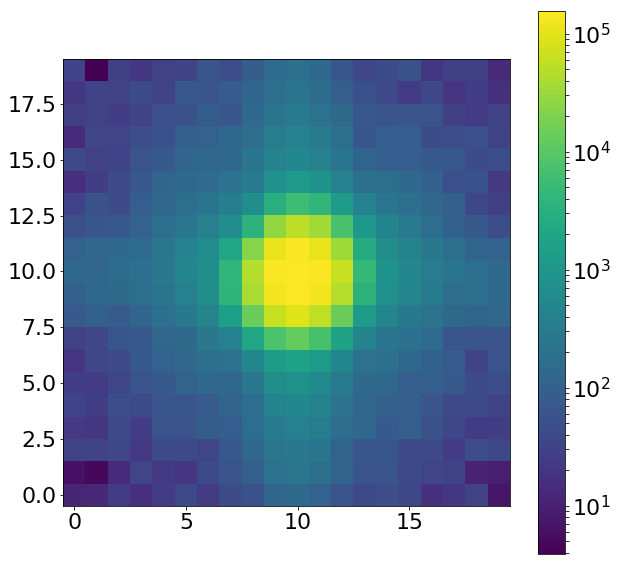

In [296]:
plt.figure(figsize=(10,10))
plt.imshow(sci_image,norm=LogNorm(),origin='lower')
plt.colorbar()

In [298]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 75, 31)
minimal likelihood is: 3735.93066805
minimal chi2 reduced is: 18.6393542467


In [299]:
size=75

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.axvline(size*6+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.axvline(6*size+0.5,ls='--')

In [300]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)
#model(allparameters_proposal)

-3735.9306680477334

In [301]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

In [302]:
plt.figure(figsize=(25,20))
plt.subplot(221)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(222)
plt.imshow(ilum,origin='lower')

In [303]:
single_analysis.create_basic_comparison_plot()

chi**2 reduced is: 18.6393542101
Abs of residual divided by total flux is: 0.0393752191245
Abs of residual divided by largest value of a flux in the image is: 0.047318255881


18.6393542101
chi**2 reduced is: 18.6393542101
Abs of residual divided by total flux is: 0.0393752191245
Abs of residual divided by largest value of a flux in the image is: 0.047318255881


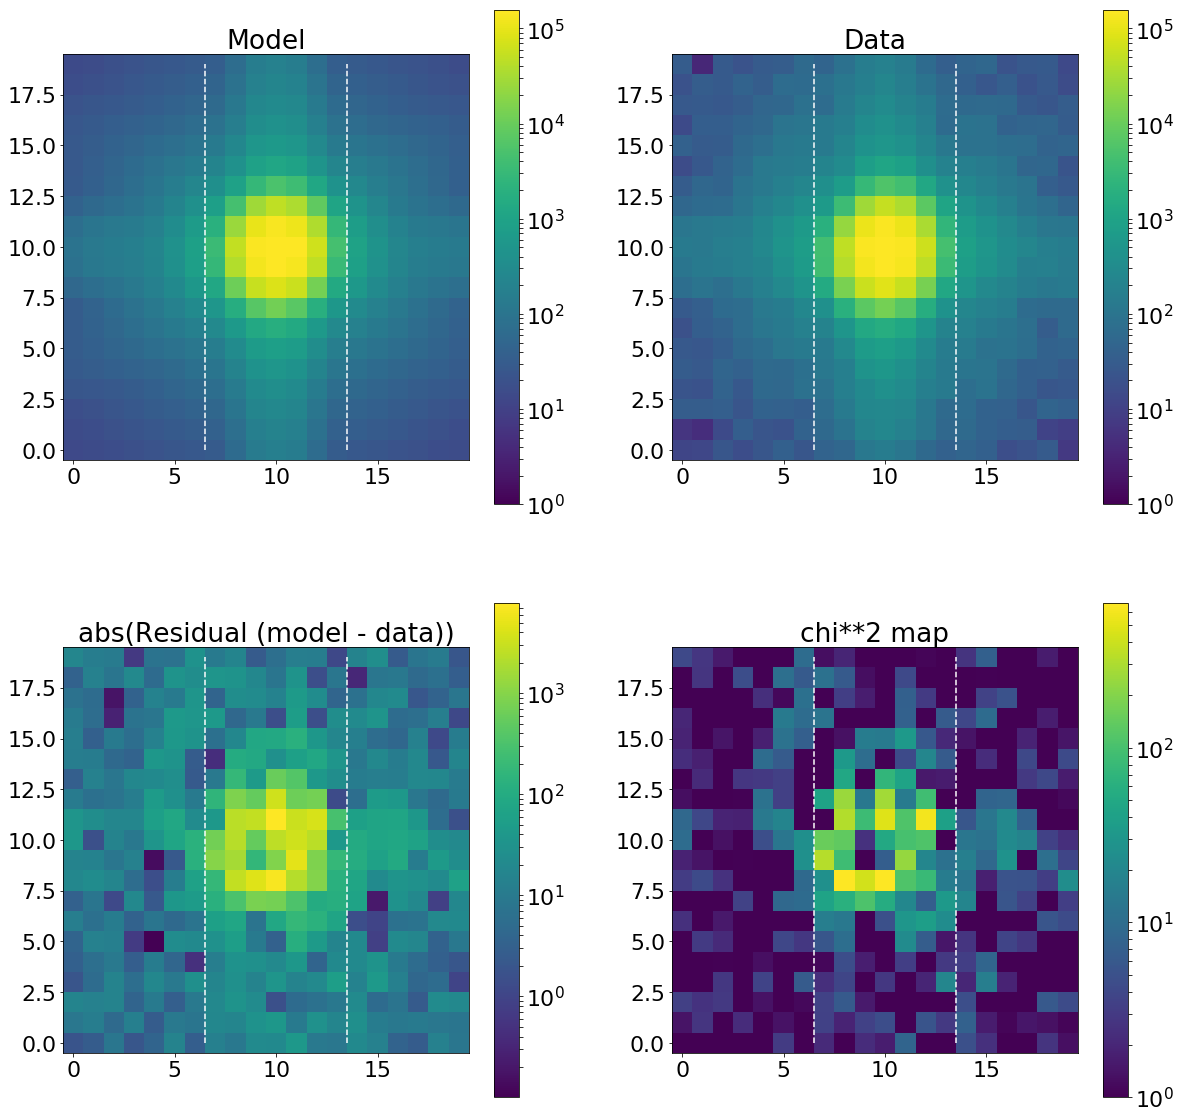

In [304]:
single_analysis.create_basic_comparison_plot_log()

18.6393542101


0.039375219124542747

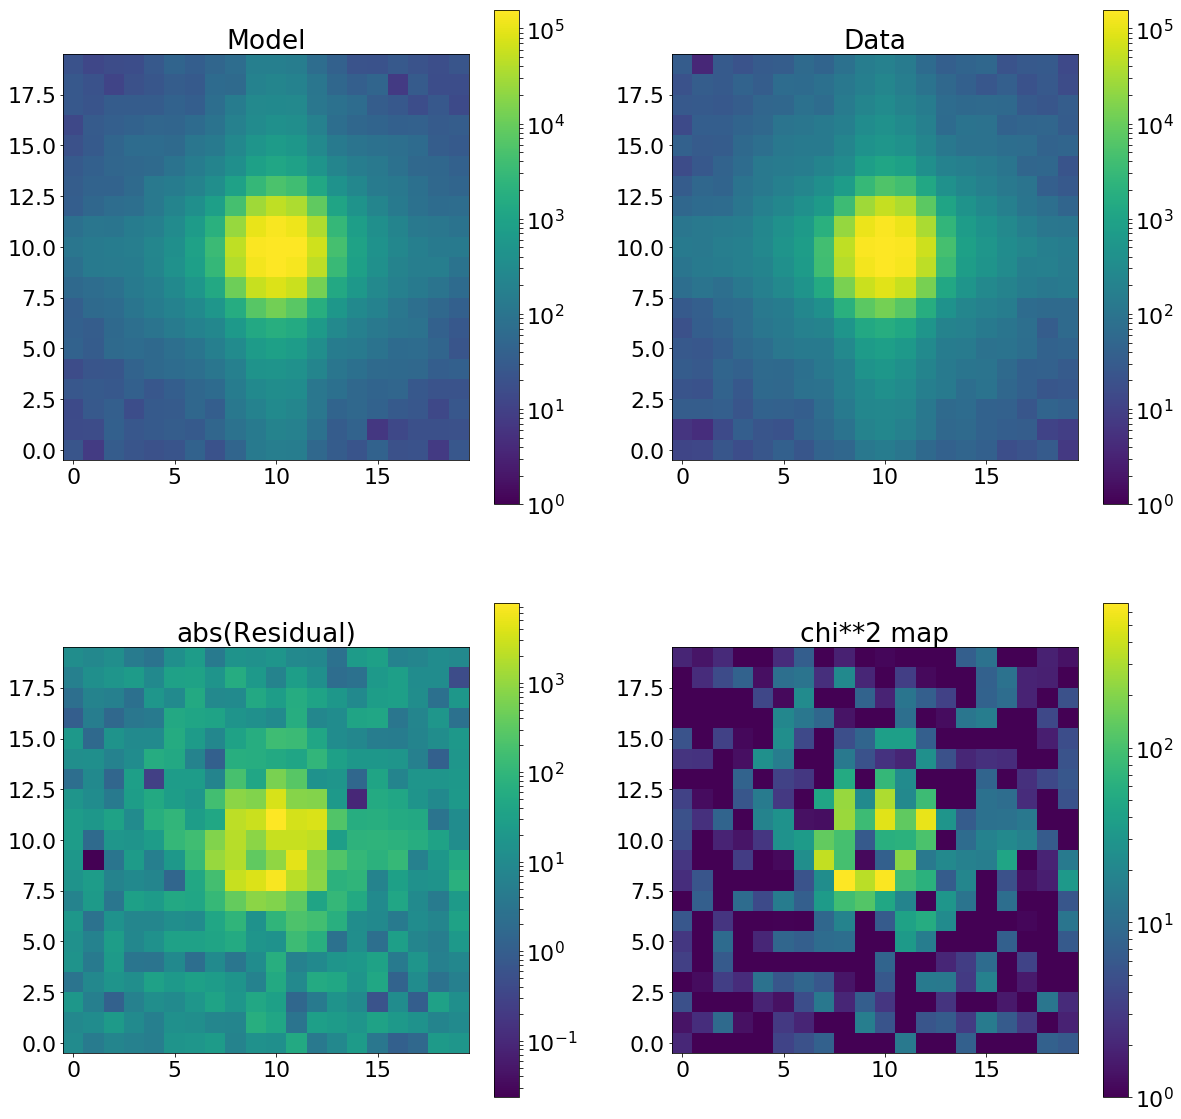

In [305]:
artifical_noise=single_analysis.create_artificial_noise()


plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
plt.colorbar()
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
plt.colorbar()
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

26.1409033486
45.7969816064


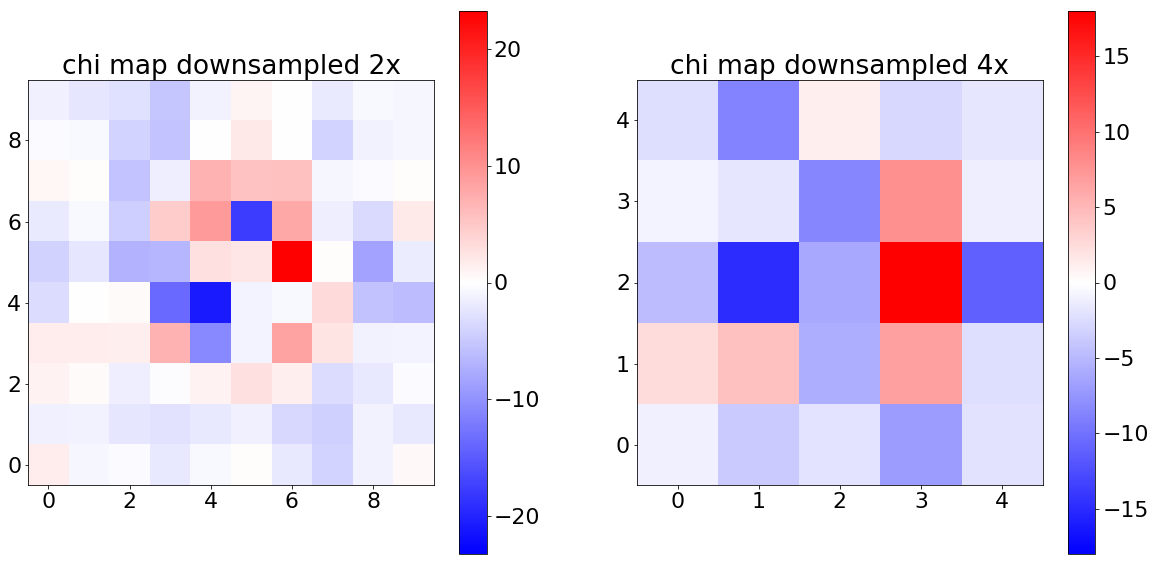

In [306]:
sci_image_2=downsample_manual_function(sci_image,int(sci_image.shape[0]/2))
sci_image_4=downsample_manual_function(sci_image,int(sci_image.shape[0]/4))

res_iapetus_2=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/2))
res_iapetus_4=downsample_manual_function(res_iapetus,int(res_iapetus.shape[0]/4))

var_image_2=downsample_manual_function(var_image,int(var_image.shape[0]/2))
var_image_4=downsample_manual_function(var_image,int(var_image.shape[0]/4))

chi_downsample_2=(res_iapetus_2-sci_image_2)/np.sqrt(var_image_2)
chi_downsample_4=(res_iapetus_4-sci_image_4)/np.sqrt(var_image_4)

print(np.mean(chi_downsample_2**2))
print(np.mean(chi_downsample_4**2))


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(chi_downsample_2,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_2)),vmax=np.max(np.abs(chi_downsample_2)))
plt.colorbar()
plt.title('chi map downsampled 2x')
plt.subplot(122)
plt.imshow(chi_downsample_4,origin='lower',cmap='bwr',vmin=-np.max(np.abs(chi_downsample_4)),vmax=np.max(np.abs(chi_downsample_4)))
plt.colorbar()
plt.title('chi map downsampled 4x')

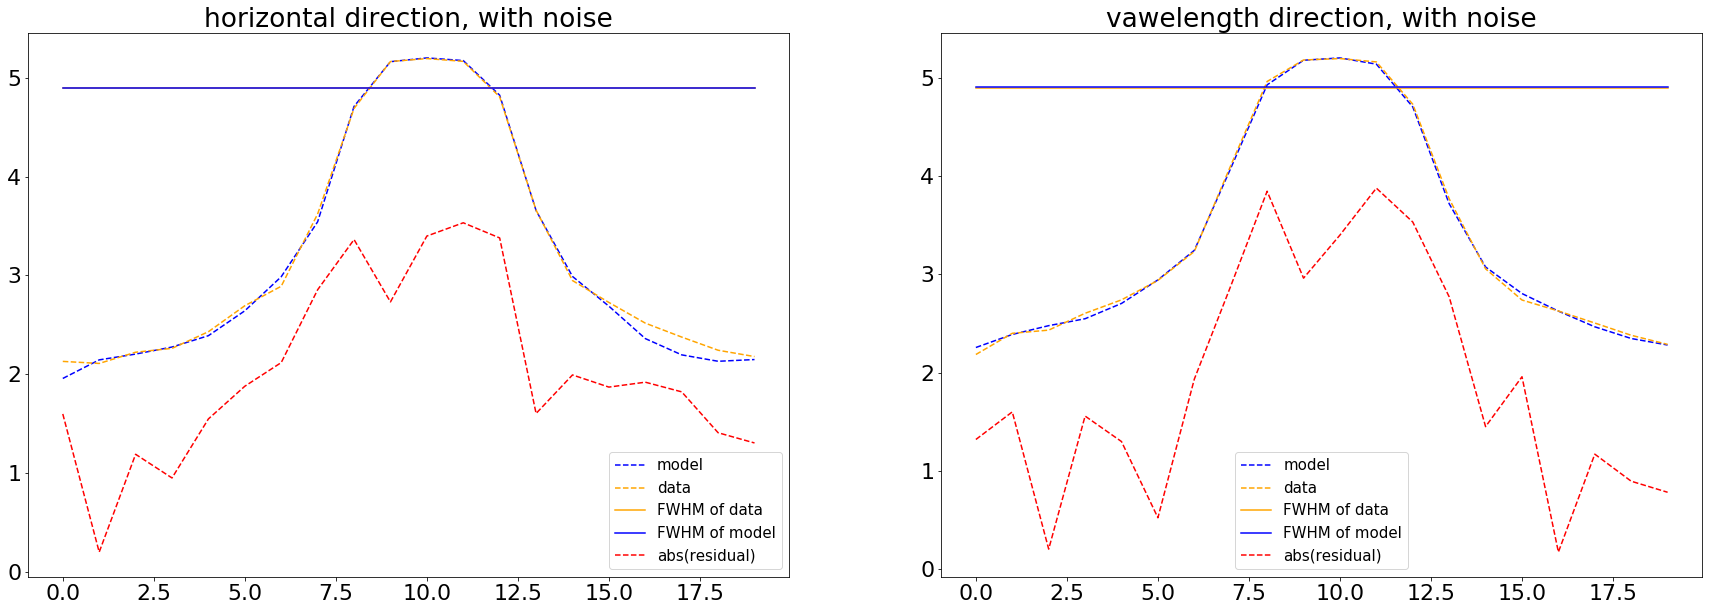

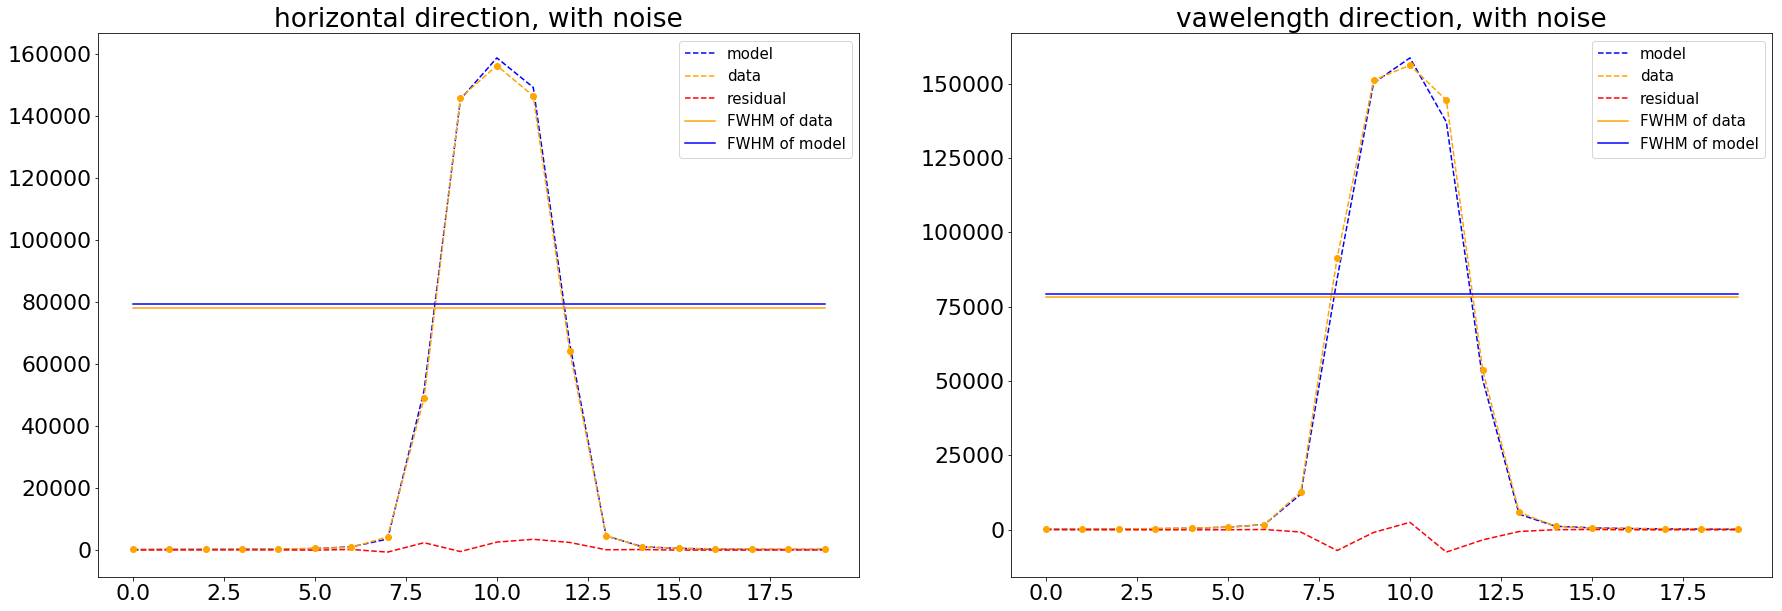

In [307]:
single_analysis.create_cut_plots()

## Total solution

In [588]:
from scipy.optimize import curve_fit
import pickle

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation.pkl', 'rb') as f:
    results_of_fit_many_interpolation=pickle.load(f)
    
def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m05','0','p05','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0','p05']
label_focusd=['m05','0','0d','p05']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [589]:
results_of_fit_many_interpolation_with_focus = {'m4': results_of_fit_many_interpolation['m4'].copy(), 
                       'm35' :results_of_fit_many_interpolation['m35'].copy(),
                       'm3' :  results_of_fit_many_interpolation['m3'].copy(),
                       'm25' : results_of_fit_many_interpolation['m25'].copy(),
                       'm2' :results_of_fit_many_interpolation['m2'].copy(),
                       'm15' : results_of_fit_many_interpolation['m15'].copy(),
                       'm1' :results_of_fit_many_interpolation['m1'].copy(),
                       'm05' : results_of_fit_many_interpolation['m05'].copy(),
                       '0d' : results_of_fit_many_interpolation['0d'].copy(),
                       '0' :  results_of_fit_many_interpolation['0'].copy(),
                       'p05' :results_of_fit_many_interpolation['p05'].copy(),
                       'p1' : results_of_fit_many_interpolation['p1'].copy(),
                       'p15': results_of_fit_many_interpolation['p15'].copy(),
                       'p2' : results_of_fit_many_interpolation['p2'].copy(),
                       'p25' :results_of_fit_many_interpolation['p25'].copy(),
                       'p3' : results_of_fit_many_interpolation['p3'].copy(),
                       'p35' : results_of_fit_many_interpolation['p35'].copy(),
                        'p4' :results_of_fit_many_interpolation['p4'].copy(),
                      '0p' :results_of_fit_many_interpolation['0p'].copy()}

In [590]:
i=0
all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,4]

all_x[all_x>int(4096/2)]=all_x[all_x>int(4096/2)]+69

all_x_in_respect_to_center=all_x-int((4096+69)/2)
all_y_in_respect_to_center=all_y-int(4176/2)

In [598]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent',
              'x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_ilum_radius','frd_sigma','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']  

In [599]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['z4','scattering_radius','scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection=results_of_fit_many[i][j]
        single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
        single_selection_z=np.full(len(single_selection),mm[label.index(i)])
        single_selection_values=single_selection.values
        single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_z,single_selection_values]))    
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]), single_parameter[:,4])
        #print(popt)


    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_with_focus[i].at[:,j]=func([all_x_in_respect_to_center,all_y_in_respect_to_center,np.full(len(all_x),mm[label.index(i)])],*popt)

/Users/nevencaplar/Documents/PFS/lsst_stack3/python/miniconda3-4.3.21/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [600]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for 2 value in focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
"""        
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)
                                           
dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many[i].index.astype(int)][:,2]

    values=[]
    for l in range(100):
        values.append(grating_lines_res[int(single_number_for_single_pos_full[l][2])])
        
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values
"""  
# have to run "next level grating with splines "
# this creates function grating_lines_fit which gives number of grating lines as a function of wavelegth
# for each spot you have to find which wavelength does it correspond

dy=[]
for i in label:
    dy=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,2]
    dfiber=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]     
    
    values=[]
    for l in range(100):
        z=fiberID[int(dfiber[l])]
        single_fiber_y_data=detector_map[3].data[z][0]
        single_fiber_x_data=detector_map[3].data[z][1]
        single_fiber_wavelength_data=detector_map[3].data[z][3]
        f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
        grating_lines_fit(f(dy[l]))
        
        values.append( grating_lines_fit(f(dy[l])))
   
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values    

In [601]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all focused measurments?
inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dx=[]
    values=[]
    for i in label_focus:
        if len(dx)==0:
            dx=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]

            values=results_of_fit_many[i][j]
        else:
            dx=np.hstack((dx,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,3]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
    fiber_r_res=[]
    for i in range(10):
        if len(values[dspot==i])>1:
            fiber_r_res.append(np.median(values[dfiber==i]))
        else:
            fiber_r_res.append(1.8)


    dx=[]
    for i in label:
        dx=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,3]
        dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]

        values=[]
        for l in range(100):
            values.append(fiber_r_res[int(single_number_for_single_pos_full[l][1])])

    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_with_focus[i].at[:,j]=values

In [602]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation_with_focus.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_with_focus,f, protocol=pickle.HIGHEST_PROTOCOL)

### next level grating with splines 

In [727]:
import astropy
from scipy.interpolate import interp1d

single_number_for_single_pos_full_y_reversed=single_number_for_single_pos_full
single_number_for_single_pos_full_y_reversed[:,4]=4176-single_number_for_single_pos_full_y_reversed[:,4]

In [728]:
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dy=[]
    values=[]
    for i in ['0','0d']:
        if len(dy)==0:
            dy=single_number_for_single_pos_full_y_reversed[results_of_fit_many[i][j].index.astype(int)][:,4]
            dspot=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]
            dfiber=single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]
            values=results_of_fit_many[i][j]
        else:
            dy=np.hstack((dy,single_number_for_single_pos_full_y_reversed[results_of_fit_many[i][j].index.astype(int)][:,4]))
            dspot=np.hstack((dspot,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,2]))
            dfiber=np.hstack((dfiber,single_number_for_single_pos_full[results_of_fit_many[i][j].index.astype(int)][:,1]))
            values=np.hstack((values,results_of_fit_many[i][j]))           
            
            
grating_lines_res=[]
for i in range(10):
    if len(values[dspot==i])>1:
        grating_lines_res.append(np.median(values[dspot==i]))
    else:
        grating_lines_res.append(100000)

In [760]:
dy

array([ 4022.,  4001.,  3971.,  3966.,  3964.,  3963.,  3970.,  3981.,
        4009.,  4033.,  3331.,  3325.,  3324.,  3323.,  3328.,  3338.,
        2623.,  2618.,  2617.,  2617.,  2623.,  2632.,  2324.,  2319.,
        2318.,  2318.,  2323.,  2332.,  1958.,  1952.,  1952.,  1952.,
        1956.,  1966.,  1597.,  1591.,  1590.,  1590.,  1595.,  1603.,
        1308.,  1305.,  1303.,  1303.,  1309.,  1317.,   862.,   848.,
         830.,   825.,   825.,   825.,   838.,   855.,   871.,  4022.,
        4001.,  3971.,  3966.,  3964.,  3963.,  3970.,  3981.,  4009.,
        4033.,  3331.,  3325.,  3324.,  3323.,  3328.,  3338.,  2623.,
        2618.,  2617.,  2617.,  2623.,  2632.,  2324.,  2319.,  2318.,
        2318.,  2323.,  2332.,  1958.,  1952.,  1952.,  1952.,  1956.,
        1966.,  1597.,  1591.,  1590.,  1590.,  1595.,  1603.,  1308.,
        1305.,  1303.,  1303.,  1309.,  1317.,   862.,   848.,   830.,
         825.,   825.,   825.,   838.,   855.,   871.])

In [730]:
fiberID=np.round(np.array([6,67,194,257,315,337,393,455,582,644])*600/650).astype(int)

dy_changed_to_dwavelength=[]
for j in range(len(dy)):
    i=fiberID[int(dfiber[j])]
    single_fiber_y_data=detector_map[3].data[i][0]
    single_fiber_x_data=detector_map[3].data[i][1]
    single_fiber_wavelength_data=detector_map[3].data[i][3]
    f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
    dy_changed_to_dwavelength.append(f(dy[j]))
    
dy_changed_to_dwavelength=np.array(dy_changed_to_dwavelength)

In [757]:
dy_changed_to_dwavelength_sorted=dy_changed_to_dwavelength[np.argsort(dy_changed_to_dwavelength)]
values_sorted=values[np.argsort(dy_changed_to_dwavelength)]
position_of_break=np.argwhere(np.diff(dy_changed_to_dwavelength_sorted)>10).ravel()
position_of_break=np.insert(position_of_break,0,0)
position_of_break=np.insert(position_of_break,len(position_of_break),len(dy_changed_to_dwavelength_sorted))
position_of_break

array([  0,  17,  29,  41,  53,  65,  77,  89, 110])

In [758]:
res_wavelength=[]
res_values=[]
for i in range(len(position_of_break)-1):
    res_wavelength.append(dy_changed_to_dwavelength_sorted[position_of_break[i]+1:position_of_break[i+1]])
    res_values.append(values_sorted[position_of_break[i]+1:position_of_break[i+1]])


In [766]:
res_wavelength

[array([ 697.22854184,  697.25174967,  697.25174967,  697.27272542,
         697.27272542,  697.38332812,  697.38332812,  697.42759497,
         697.42759497,  697.43178756,  697.43178756,  697.83892448,
         697.83892448,  697.97270674,  697.97270674,  698.14675173]),
 array([ 739.02747411,  739.02747411,  739.2103927 ,  739.2103927 ,
         739.22304507,  739.22304507,  739.22751872,  739.22751872,
         739.5535851 ,  739.5535851 ,  739.81163684]),
 array([ 764.11355855,  764.11355855,  764.17762361,  764.17762361,
         764.21864752,  764.21864752,  764.2232293 ,  764.2232293 ,
         764.45526048,  764.45526048,  764.69834843]),
 array([ 795.40960279,  795.40960279,  795.45762513,  795.45762513,
         795.60683903,  795.60683903,  795.61153873,  795.61153873,
         795.74945294,  795.74945294,  796.1487438 ]),
 array([ 827.00158013,  827.00158013,  827.05546061,  827.05546061,
         827.17192172,  827.17192172,  827.17670883,  827.17670883,
         827.3933

In [767]:
res_values

[array([ 119998.48365842,  119995.47867269,  118649.32429235,
         119998.06906931,  119494.10968624,  119943.23757545,
          78315.27668794,   99538.26368386,   92234.09817635,
         119957.27534766,  119982.37902245,  119993.63991218,
         119893.57866879,   73163.98040842,   71432.26642004,
         101685.86724382]),
 array([ 119998.41940895,   78189.13427228,  108399.93807355,
          70199.39420998,  119944.42201394,  119850.34635072,
         119914.92107562,   67919.04624861,   55495.82930213,
          88459.73399721,   80716.06818281]),
 array([ 119996.05685634,  119996.80476153,  119998.36361752,
         119998.84104097,  114408.18780513,   90532.61972538,
         116030.16257596,  105718.93569383,   98959.24145629,
         105847.83407626,   82464.96533262]),
 array([ 119491.40962055,  119999.67875944,  102542.58264461,
         119994.91917202,  114761.35733436,  100690.20370049,
         119995.40532503,  119996.63893981,   87046.0861155 ,
          76

In [768]:
res_res_wavelength=[]
res_res_values=[]
for i in res_wavelength:
    res_res_wavelength.append(np.median(i))
    
for i in res_values:
    res_res_values.append(np.median(i))

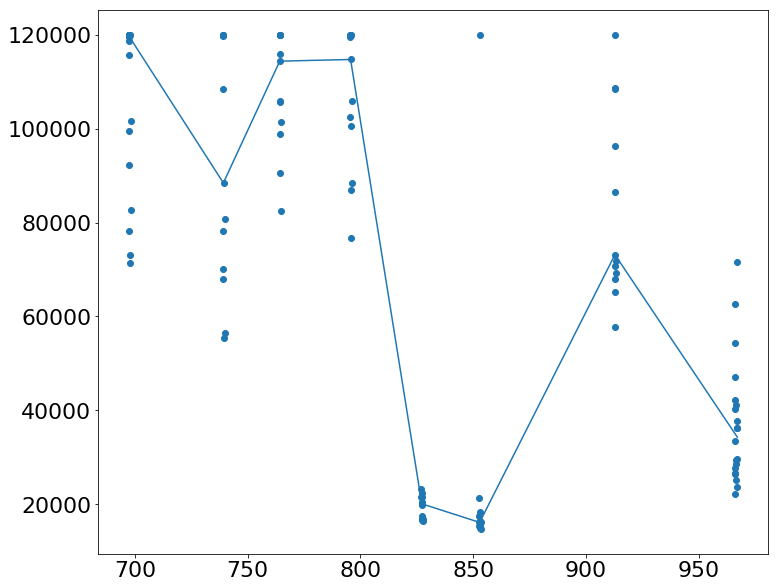

In [771]:
grating_lines_fit=interp1d(res_res_wavelength,res_res_values,fill_value="extrapolate")
plt.scatter(dy_changed_to_dwavelength,values)
plt.plot(dy_changed_to_dwavelength_sorted,grating_lines_fit(dy_changed_to_dwavelength_sorted))

In [772]:
dy=[]
for i in label:
    dy=single_number_for_single_pos_full_y_reversed[results_of_fit_many_interpolation[i].index.astype(int)][:,4]
    dspot=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,2]
    dfiber=single_number_for_single_pos_full[results_of_fit_many_interpolation[i].index.astype(int)][:,1]     
    
    values=[]
    for l in range(100):
        z=fiberID[int(dfiber[l])]
        single_fiber_y_data=detector_map[3].data[z][0]
        single_fiber_x_data=detector_map[3].data[z][1]
        single_fiber_wavelength_data=detector_map[3].data[z][3]
        f = interp1d(single_fiber_y_data, single_fiber_wavelength_data,fill_value="extrapolate")
        f(grating_lines_fit(dy[l]))
        
        values.append(f(grating_lines_fit(dy[l])))
   
for i in label:
    z=mm[label.index(i)]
    results_of_fit_many_interpolation_with_focus[i].at[:,j]=values

### verification 

In [544]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Oct10'
descriptions=results_of_fit_many_interpolation_with_focus[label[0]].columns
for j in tqdm([7,8,9,10]):
    for i in range(0,len(descriptions)):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Interpolation: '+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()


100%|███████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.33s/it]


In [363]:
results_of_fit_many_interpolation_with_focus['0d']['frd_sigma']

0.0     0.092845
1.0     0.117907
2.0     0.108666
3.0     0.010012
4.0     0.034516
5.0     0.128359
6.0     0.133913
7.0     0.101797
8.0     0.134559
9.0     0.133111
10.0    0.092845
11.0    0.117907
12.0    0.108666
13.0    0.010012
14.0    0.034516
15.0    0.128359
16.0    0.133913
17.0    0.101797
18.0    0.134559
19.0    0.133111
20.0    0.092845
21.0    0.117907
22.0    0.108666
23.0    0.010012
24.0    0.034516
25.0    0.128359
26.0    0.133913
27.0    0.101797
28.0    0.134559
29.0    0.133111
          ...   
70.0    0.092845
71.0    0.117907
72.0    0.108666
73.0    0.010012
74.0    0.034516
75.0    0.128359
76.0    0.133913
77.0    0.101797
78.0    0.134559
79.0    0.133111
80.0    0.092845
81.0    0.117907
82.0    0.108666
83.0    0.010012
84.0    0.034516
85.0    0.128359
86.0    0.133913
87.0    0.101797
88.0    0.134559
89.0    0.133111
90.0    0.092845
91.0    0.117907
92.0    0.108666
93.0    0.010012
94.0    0.034516
95.0    0.128359
96.0    0.133913
97.0    0.1017

# Simulating images

## creating pandas

In [625]:
import astropy
from astropy.io import fits

detector_map = fits.open('/Users/nevencaplar/Documents/PFS/DetectorMap/pfsDetectorMap-005833-r1.fits')




In [903]:
from scipy.optimize import curve_fit
import pickle

with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct122018/' + 'results_of_fit_many_interpolation_with_focus.pkl', 'rb') as f:
    results_of_fit_many_interpolation_with_focus=pickle.load(f)


def func_focus(x,a1,a2,b1,b2,d,a1b1):
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+d+a1b1*x[0]*x[1]

In [906]:
j=0
#x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
#y=4294-single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()

all_x=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,3]
all_y=single_number_for_single_pos_full[results_of_fit_many_interpolation_with_focus[label[i]].index.astype(int)][:,4]

all_x[all_x>int(4096/2)]=all_x[all_x>int(4096/2)]+69

all_x_in_respect_to_center=all_x-int((4096+69)/2)
all_y_in_respect_to_center=all_y-int(4176/2)


In [907]:
parameters_that_vary_as_xy=['z4','z5','z6','z7','z8','z9','z10','z11','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                            'det_vert','slitHolder_frac_dx','scattering_radius','scattering_slope','scattering_amplitude','pixel_effect']
parameters_that_vary_as_fiber=['fiber_r','frd_sigma','radiometricEffect','radiometricExponent','x_ilum','y_ilum','x_fiber','y_fiber','effective_ilum_radius']
parameters_that_vary_as_wavelength=['grating_lines']


In [908]:
# parameters that vary slowly across the detector - describing wavefront and pupil (without illumination of the pupil)
parameters_for_func_focus_that_vary_as_xy=[]
single_parameter=[]
for j in parameters_that_vary_as_xy:

    single_selection=results_of_fit_many_interpolation_with_focus['0'][j]
    single_selection_x=all_x_in_respect_to_center[single_selection.index.astype(int)]
    single_selection_y=all_y_in_respect_to_center[single_selection.index.astype(int)]
    single_selection_values=single_selection.values
    single_selection_array=np.transpose(np.array([single_selection.index,single_selection_x,single_selection_y,single_selection_values]))    

    single_parameter=single_selection_array


    popt, pcov = curve_fit(func_focus, xdata=np.transpose(single_parameter[:,[1,2]]), ydata=single_parameter[:,3],p0=[0,0,0,0,0,0])
    parameters_for_func_focus_that_vary_as_xy.append(popt)
    print(str(j)+' '+str(popt))
    #print(str(j)+' '+str(func_focus([2100,0],*popt)))

parameters_for_func_focus_that_vary_as_xy=np.array(parameters_for_func_focus_that_vary_as_xy)

z4 [-0.00001148  0.00000024  0.0001514   0.00000007 -0.65227766 -0.00000001]
z5 [ 0.00002076  0.00000007  0.00007841 -0.00000001 -0.23661718 -0.00000026]
z6 [ 0.00001076  0.00000013  0.00005542 -0.00000024 -0.14074264  0.00000002]
z7 [ 0.00011376 -0.00000003  0.00010435 -0.00000004  0.54607933 -0.00000007]
z8 [-0.00022381 -0.         -0.00000242  0.00000003 -0.05561376 -0.00000001]
z9 [ 0.0000348   0.00000002  0.00004312 -0.00000002 -0.16370656  0.        ]
z10 [ 0.00002769 -0.         -0.00001455 -0.00000001 -0.2819536   0.00000003]
z11 [-0.00001499  0.00000008  0.00008186  0.00000008 -0.43671165  0.00000004]
hscFrac [-0.00000649  0.00000001  0.00000287  0.          0.65417141  0.        ]
strutFrac [-0.00000333  0.          0.00000158  0.          0.07572842  0.        ]
dxFocal [ 0.00008448 -0.00000001 -0.00000106 -0.         -0.00207493  0.        ]
dyFocal [ 0.00007415 -0.00000001 -0.00009063 -0.00000001  0.08968609  0.        ]
slitFrac [-0.00000043 -0.          0.00000205 -0.   

In [909]:
parameters_for_func_focus_that_vary_as_fiber=[]
for j in range(len(parameters_that_vary_as_fiber)):
    parameters_for_func_focus_that_vary_as_fiber.append([np.median(results_of_fit_many_interpolation_with_focus['0'][parameters_that_vary_as_fiber[j]]),np.std(results_of_fit_many_interpolation_with_focus['0'][parameters_that_vary_as_fiber[j]])])
    print(str(parameters_that_vary_as_fiber[j])+str(parameters_for_func_focus_that_vary_as_fiber[-1]))       


fiber_r[1.8774008081537898, 0.03878945764547982]
frd_sigma[0.1132864415082766, 0.04132711615903417]
radiometricEffect[0.67636198527276692, 0.1473797217518026]
radiometricExponent[0.64185182071307656, 0.28507785386208295]
x_ilum[0.047802537356487394, 0.04395252315699463]
y_ilum[0.067474806412326685, 0.02753514168350894]
x_fiber[-0.021363945553947383, 0.03459866537620169]
y_fiber[0.038253712992682348, 0.08429583361136656]
effective_ilum_radius[0.93599567858684107, 0.03525247419814343]


In [912]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Oct10'
descriptions=results_of_fit_many_interpolation_with_focus[label[0]].columns
for j in tqdm([7,8,9,10]):
    for i in range(0,3):

        x=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[3]].ravel()
        y=single_number_for_single_pos_full[np.array(results_of_fit_many_interpolation_with_focus[label[j]][descriptions[i]].index).astype(int)][:,[4]].ravel()
        values=func_focus([x-int((4096+69)/2),y-int(4176/2)],*parameters_for_func_focus_that_vary_as_xy[i])
        colors=values
        area = np.pi * (15 * 1)**2  # 0 to 15 point radii

        # z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+min_dif
            min_colors=median_color-min_dif
            

            
        #'z4,dx,dy,chi'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=max(colors)
            min_colors=min(colors)

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4416)
        plt.xlim(0,4294)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Simulation: '+str(label[j])+" "+str(descriptions[i]))


        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneSimulation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneSimulation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()
        
        
        


100%|███████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.27s/it]


In [913]:
number_of_spots=25
number_of_fibers=600

fiber_list=[]
for i in range(1,number_of_fibers+1):
    fiber_list.append('fiber_'+str(i))

fiber_array=np.repeat(fiber_list,number_of_spots)

spot_list=[]
for i in range(1,number_of_spots+1):
    spot_list.append(np.repeat('spot_'+str(i),number_of_fibers))
    
spot_array=np.transpose(np.array(spot_list)).ravel()


arrays=[fiber_array,spot_array]

df = pd.DataFrame(np.zeros((number_of_spots*number_of_fibers,len(columns))), index=arrays,columns=columns)

In [917]:
par=1
#probably not correct
if np.mean(single_fiber_x_data)>((4096)/2):
    single_fiber_x_data=single_fiber_x_data+69
else:
    pass

func_focus([single_fiber_x_data-int((4096+69)/2),single_fiber_y_data-int(4176/2)],*parameters_for_func_focus_that_vary_as_xy[par])

array([ 0.96875401,  0.90026057,  0.83142647,  0.76218826,  0.69249777,
        0.6223125 ,  0.55116157,  0.47988069,  0.40800903,  0.33552053,
        0.26239214,  0.18860199,  0.11367132,  0.03849486, -0.03740027,
       -0.11403248, -0.19142037, -0.26958362, -0.34903014, -0.428814  ,
       -0.50944222, -0.59094252, -0.67334596, -0.7566896 , -0.84153805])

In [918]:
# function of detector

for fiber_i in range(number_of_fibers):
    single_fiber_y_data=detector_map[3].data[fiber_i][0]-int((4096+69)/2)
    single_fiber_x_data=detector_map[3].data[fiber_i][1]-int(4176/2)
    single_fiber_wavelength_data=detector_map[3].data[fiber_i][3]
    for par in range(len(parameters_for_func_focus_that_vary_as_xy)):
        df.loc[['fiber_'+str(fiber_i+1)],parameters_that_vary_as_xy[par]]=func_focus([single_fiber_x_data,single_fiber_y_data],*parameters_for_func_focus_that_vary_as_xy[par])
        
        
# function of fiber 

for fiber_i in range(number_of_fibers):
    single_fiber_y_data=detector_map[3].data[fiber_i][0]-int((4096+69)/2)
    single_fiber_x_data=detector_map[3].data[fiber_i][1]-int(4176/2)
    single_fiber_wavelength_data=detector_map[3].data[fiber_i][3]
    for par in range(len(parameters_that_vary_as_fiber)):
        df.loc[['fiber_'+str(fiber_i+1)],parameters_that_vary_as_fiber[par]]=np.random.randn()*parameters_for_func_focus_that_vary_as_fiber[par][1]+parameters_for_func_focus_that_vary_as_fiber[par][0]
        
# flux

for fiber_i in range(number_of_fibers):
    single_fiber_y_data=detector_map[3].data[fiber_i][0]-int((4096+69)/2)
    single_fiber_x_data=detector_map[3].data[fiber_i][1]-int(4176/2)
    single_fiber_wavelength_data=detector_map[3].data[fiber_i][3]
    for par in range(len(['flux'])):
        df.loc[['fiber_'+str(fiber_i+1)],['flux']]=1
        
# grating lines        

for fiber_i in range(number_of_fibers):
    single_fiber_y_data=detector_map[3].data[fiber_i][0]-int((4096+69)/2)
    single_fiber_x_data=detector_map[3].data[fiber_i][1]-int(4176/2)
    single_fiber_wavelength_data=detector_map[3].data[fiber_i][3]
    for par in range(len(['grating_lines'])):
        df.loc[['fiber_'+str(fiber_i+1)],['grating_lines']]=grating_lines_fit(single_fiber_wavelength_data)


In [919]:
df.to_pickle("/Users/nevencaplar/Documents/PFS/Simulations/df_v01.pkl")

In [920]:
df

z4        z5        z6        z7        z8        z9  \
fiber_1   spot_1   0.260930 -1.188993 -0.558055 -0.473738  0.476554 -0.301180   
          spot_2   0.246987 -1.082179 -0.410126 -0.406325  0.461407 -0.284474   
          spot_3   0.236957 -0.976317 -0.274974 -0.341259  0.447749 -0.268712   
          spot_4   0.230805 -0.871368 -0.152624 -0.278516  0.435572 -0.253897   
          spot_5   0.228510 -0.767298 -0.043091 -0.218078  0.424874 -0.240028   
          spot_6   0.230053 -0.664077  0.053611 -0.159929  0.415649 -0.227108   
          spot_7   0.235466 -0.561053  0.137946 -0.103721  0.407853 -0.215068   
          spot_8   0.244670 -0.459459  0.208876 -0.050127  0.401578 -0.204054   
          spot_9   0.257677 -0.358642  0.266948  0.001211  0.396770 -0.193991   
          spot_10  0.274480 -0.258583  0.312155  0.050303  0.393428 -0.184880   
          spot_11  0.295073 -0.159261  0.344492  0.097157  0.391551 -0.176722   
          spot_12  0.319452 -0.060659  0.363955  0.141779  0.391137 -0.169516   
          spot_13  0.347801  0.037842  0.370541  0.184430  0.392199 -0.163228   
          spot_14  0.379775  0.135058  0.364168  0.224594  0.394723 -0.157934   
          spot_15  0.415539  0.231612  0.344918  0.262544  0.398713 -0.153593   
          spot_16  0.455098  0.327526  0.312789  0.298283  0.404170 -0.150207   
          spot_17  0.498461  0.422821  0.267785  0.331817  0.411095 -0.147773   
          spot_18  0.545637  0.517525  0.209908  0.363149  0.419493 -0.146293   
          spot_19  0.596965  0.612240  0.138689  0.392456  0.429429 -0.145767   
          spot_20  0.651833  0.705842  0.055000  0.419385  0.440788 -0.146199   
          spot_21  0.710559  0.798945 -0.041546  0.444126  0.453628 -0.147585   
          spot_22  0.773163  0.891588 -0.150943  0.466685  0.467955 -0.149924   
          spot_23  0.839667  0.983815 -0.273184  0.487068  0.483774 -0.153215   
          spot_24  0.910115  1.075688 -0.408250  0.505278  0.501095 -0.157458   
          spot_25  0.985020  1.167838 -0.557071  0.521414  0.520048 -0.162687   
fiber_2   spot_1   0.255276 -1.187678 -0.561375 -0.471378  0.475323 -0.301425   
          spot_2   0.241336 -1.081114 -0.413417 -0.404044  0.460172 -0.284715   
          spot_3   0.231306 -0.975502 -0.278237 -0.339055  0.446510 -0.268949   
          spot_4   0.225153 -0.870801 -0.155861 -0.276388  0.434330 -0.254129   
          spot_5   0.222855 -0.766979 -0.046303 -0.216025  0.423628 -0.240257   
...                     ...       ...       ...       ...       ...       ...   
fiber_599 spot_21  0.510182 -0.508228  0.064180  0.512156 -0.469251  0.002928   
          spot_22  0.563582 -0.583530 -0.032047  0.486217 -0.459428  0.002854   
          spot_23  0.620838 -0.659740 -0.141078  0.458015 -0.448237  0.001849   
          spot_24  0.681985 -0.736896 -0.262889  0.427534 -0.435688 -0.000080   
          spot_25  0.747470 -0.815525 -0.398319  0.394550 -0.421704 -0.002949   
fiber_600 spot_1   0.246623  0.849764 -0.711534  0.568494 -0.375096 -0.192597   
          spot_2   0.223654  0.787306 -0.550334  0.586165 -0.393068 -0.173866   
          spot_3   0.204612  0.724501 -0.401959  0.601730 -0.409669 -0.156067   
          spot_4   0.189459  0.661286 -0.266424  0.615177 -0.424893 -0.139202   
          spot_5   0.178172  0.597614 -0.143739  0.626495 -0.438735 -0.123275   
          spot_6   0.170728  0.533442 -0.033912  0.635672 -0.451191 -0.108287   
          spot_7   0.167102  0.468337  0.063607  0.642738 -0.462322 -0.094155   
          spot_8   0.167323  0.403061  0.147623  0.647599 -0.471989 -0.081054   
          spot_9   0.171347  0.337190  0.218768  0.650296 -0.480262 -0.068894   
          spot_10  0.179164  0.270699  0.277036  0.650824 -0.487141 -0.057677   
          spot_11  0.190766  0.203564  0.322428  0.649176 -0.492623 -0.047402   
          spot_12  0.206148  0.135764  0.354942  0.645347 -0.496708 -0.038071   
          spot_13  0.225436  0.066857  0.374659  0.63928

## creating images

In [921]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module_Simulation
from Zernike_Module_Simulation import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [922]:
sci_template_image=np.ones((20,20))
var_template_image=np.ones((20,20))

In [923]:
model = LN_PFS_single(sci_template_image,var_template_image,pupil_parameters=None,use_pupil_parameters=None,save=0)

In [951]:
df.loc[('fiber_299','spot_25')].values

array([    -0.09914965,     -0.08192595,     -0.9423377 ,      0.59746159,
            0.06651319,     -0.15203565,     -0.33856438,      0.0261954 ,
            0.66673736,      0.097221  ,     -0.02225168,     -0.12706137,
            0.06362887,      0.08387412,      0.44133857,      0.86449196,
            0.07991486,      0.08504655,     -0.06044943,      0.15956453,
            0.91270102,      0.21601803,      1.11065727,     -0.00582426,
        32189.76602694,     22.57291445,      2.05721644,      0.12156766,
            0.51689427,      1.9604972 ,      1.        ])

In [952]:
model(df.loc[('fiber_299','spot_25')].values)

-1343.5706983271848

In [953]:
optPsf_cut_grating_convolved_simulation_cut=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved_simulation_cut.npy') 

In [954]:
plt.imshow(optPsf_cut_grating_convolved_simulation_cut, norm=LogNorm())
plt.colorbar()

# Investigation of edges

In [28]:
from scipy.interpolate import UnivariateSpline
single_number_for_single_pos_full\
=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

In [12]:
obs='8552'
single_number='72'
image_index=int(single_number)
eps=5
#date='Sep27'
date='Oct12'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')
    

In [13]:
x=range(0,31)
y=sci_image[:,30][0:31]
yreduced05b = np.array(y) - np.max(sci_image[:,30][0:31])*0.5
yreduced01b = np.array(y) - np.max(sci_image[:,30][0:31])*0.1
freduced05b =UnivariateSpline(x, yreduced05b, s=0)
freduced01b =UnivariateSpline(x, yreduced01b, s=0)
print(freduced05b.roots())
print(freduced01b.roots())

x=range(30,60)
y=sci_image[:,30][30:60]
yreduced05t = np.array(y) - np.max(sci_image[:,30][30:60])*0.5
yreduced01t = np.array(y) - np.max(sci_image[:,30][30:60])*0.1
freduced05t =UnivariateSpline(x, yreduced05t, s=0)
freduced01t =UnivariateSpline(x, yreduced01t, s=0)
print(freduced05t.roots())
print(freduced01t.roots())


[ 12.60978359  21.25551428]
[  9.62712154  22.93015857]
[ 38.25824221  46.50547015]
[ 36.55095924  49.64090294]


In [139]:
mask = np.isin(single_number_for_single_pos_full[:,1], [0,1,2,3,4,5,6,7,8,9])

single_number_for_single_pos_full_selection=single_number_for_single_pos_full[mask]

In [194]:
from scipy.signal import argrelextrema

IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/FRDeffects/'
if not os.path.exists(IMAGES_FOLDER):
    os.makedirs(IMAGES_FOLDER)
print('Images are in folder: '+str(IMAGES_FOLDER))


res8552=[]
for j in single_number_for_single_pos_full_selection[:,0].astype(int):
    print(j)
    obs='8552'
    single_number=str(j)
    image_index=int(single_number)

    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')
    

    res=[]
    for i in range(60):
        res.append(np.mean(sci_image[:,i]))

    res=np.array(res)
    mid_position_x=int(np.mean(argrelextrema(res, np.greater)[0][np.logical_and(np.array(argrelextrema(res, np.greater)[0]>10),np.array(argrelextrema(res, np.greater)[0]<50))]))

    
    mid_position=int(list(sci_image[:,mid_position_x]).index(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)][int(len(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)])/2)]))
    
    x=range(0,mid_position+1)
    y=sci_image[:,mid_position_x][0:mid_position+1]
    yreduced05b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.6
    yreduced01b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.2
    freduced05b =UnivariateSpline(x, yreduced05b, s=0)
    freduced01b =UnivariateSpline(x, yreduced01b, s=0)
    print(freduced05b.roots())
    print(freduced01b.roots())

    x=range(mid_position,60)
    y=sci_image[:,mid_position_x][mid_position:60]
    yreduced05t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.6
    yreduced01t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.2
    freduced05t =UnivariateSpline(x, yreduced05t, s=0)
    freduced01t =UnivariateSpline(x, yreduced01t, s=0)
    print(freduced05t.roots())
    print(freduced01t.roots())

    
    plt.figure(figsize=(25,10))

    plt.subplot(121)
    plt.imshow(sci_image,norm=LogNorm(),origin='lower')
    plt.subplot(122)
    plt.plot(range(0,mid_position+1),sci_image[:,mid_position_x][0:mid_position+1],color='b')
    plt.axvline(freduced05b.roots()[0],ls='--',color='b')
    plt.axvline(freduced05b.roots()[1],ls='--',color='b')
    plt.axvline(freduced01b.roots()[0],ls=':',color='b')
    plt.axvline(freduced01b.roots()[1],ls=':',color='b')
    plt.plot(range(mid_position,60),sci_image[:,mid_position_x][mid_position:60],color='r')
    plt.axvline(freduced05t.roots()[0],ls='--',color='r')
    plt.axvline(freduced05t.roots()[1],ls='--',color='r')
    plt.axvline(freduced01t.roots()[0],ls=':',color='r')
    plt.axvline(freduced01t.roots()[1],ls=':',color='r')
    
    plt.savefig(IMAGES_FOLDER+'/8552'+str(j)+'.png')
    plt.close()
    
    res8552.append(np.concatenate((np.abs(freduced05b.roots()[-2:]-freduced01b.roots()[-2:]),np.abs(freduced05t.roots()[-2:]-freduced01t.roots()[-2:]))))
    
res8552=np.array(res8552)

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/FRDeffects/
0
[  6.81812871  10.27652163]
[  5.59708393  11.35277063]
[ 28.07913504  37.87363682]
[ 26.69310429  44.31856616]
1
[  7.53571332  11.96465479]
[  5.04247618  13.7904912 ]
[ 30.13650226  43.15962837]
[ 28.48345331  49.33663989]
2
[  8.51435669  12.19530467]
[  6.45959764  13.55276879]
[ 31.11698078  41.74355595]
[ 29.65304084  46.57633246]
3
[  9.82749042  13.43120401]
[  7.43916054  14.67435335]
[ 32.39429993  41.29947827]
[ 30.89215216  46.34296732]
4
[ 10.0244371   14.04847052]
[  7.30581373  15.31163057]
[ 33.16085158  42.54594548]
[ 31.77730436  47.25067527]
5
[  8.60779713  12.78889711]
[  5.72647686  14.245061  ]
[ 32.18817855  44.12005202]
[ 30.70211281  49.25373135]
6
[ 11.56785948  17.32191176]
[  9.11848958  18.82287628]
[ 36.91433283  45.10493604]
[ 35.41832734  49.60364347]
7
[ 13.8496029   21.29038562]
[ 12.33587836  22.7311721 ]
[ 40.51128588  47.23837005]
[ 39.21223884  50.58985668]
8
[ 10.3250949

71
[ 10.93135477  18.56805443]
[  8.06452449  19.95832344]
[ 35.82778599  45.25433219]
[ 34.31079101  49.25606438]
72
[ 13.56974107  20.86507648]
[ 10.72985019  22.16186372]
[ 38.57942754  45.61327397]
[ 37.18102118  48.59854308]
73
[ 15.10259824  22.19351199]
[ 12.61117264  23.4402562 ]
[ 39.78707931  45.42448814]
[ 38.50397225  48.62546933]
74
[ 15.73067928  24.11811778]
[ 12.90940588  25.41503719]
[ 41.98071126  47.47963882]
[ 40.66124759  50.11029252]
75
[ 10.93404522  21.06580665]
[  8.69461856  22.36322076]
[ 38.9744113   47.36351026]
[ 37.57270329  50.27216022]
76
[ 15.01197991  26.08863814]
[ 13.34590435  27.52952907]
[ 44.04056774  49.37840417]
[ 42.65100104  52.05987827]
77
[ 15.55642842  27.69363867]
[ 14.29656413  29.38275246]
[ 45.59491999  49.46643055]
[ 44.38726341  51.78496511]
78
[ 13.53626318  23.12814494]
[ 11.32234012  25.81849668]
[ 44.21368852  51.05934038]
[ 42.5801864   53.80798044]
79
[ 12.76053336  24.39340018]
[ 10.32688385  26.12464045]
[ 42.73638368  47.801

In [196]:
IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/FRDeffects/'
if not os.path.exists(IMAGES_FOLDER):
    os.makedirs(IMAGES_FOLDER)
print('Images are in folder: '+str(IMAGES_FOLDER))


res8627=[]
for j in single_number_for_single_pos_full_selection[:,0].astype(int):
    print(j)
    obs='8627'
    single_number=str(j)
    image_index=int(single_number)

    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')
    
    res=[]
    for i in range(60):
        res.append(np.mean(sci_image[:,i]))

    res=np.array(res)
    mid_position_x=int(np.mean(argrelextrema(res, np.greater)[0][np.logical_and(np.array(argrelextrema(res, np.greater)[0]>10),np.array(argrelextrema(res, np.greater)[0]<50))]))    
    
    mid_position=int(list(sci_image[:,mid_position_x]).index(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)][int(len(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)])/2)]))
    
    x=range(0,mid_position+1)
    y=sci_image[:,mid_position_x][0:mid_position+1]
    yreduced05b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.6
    yreduced01b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.2
    freduced05b =UnivariateSpline(x, yreduced05b, s=0)
    freduced01b =UnivariateSpline(x, yreduced01b, s=0)
    print(freduced05b.roots())
    print(freduced01b.roots())

    x=range(mid_position,60)
    y=sci_image[:,mid_position_x][mid_position:60]
    yreduced05t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.6
    yreduced01t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.2
    freduced05t =UnivariateSpline(x, yreduced05t, s=0)
    freduced01t =UnivariateSpline(x, yreduced01t, s=0)
    print(freduced05t.roots())
    print(freduced01t.roots())

    
    plt.figure(figsize=(25,10))

    plt.subplot(121)
    plt.imshow(sci_image,norm=LogNorm(),origin='lower')
    plt.subplot(122)
    plt.plot(range(0,mid_position+1),sci_image[:,mid_position_x][0:mid_position+1],color='b')
    plt.axvline(freduced05b.roots()[0],ls='--',color='b')
    plt.axvline(freduced05b.roots()[1],ls='--',color='b')
    plt.axvline(freduced01b.roots()[0],ls=':',color='b')
    plt.axvline(freduced01b.roots()[1],ls=':',color='b')
    plt.plot(range(mid_position,60),sci_image[:,mid_position_x][mid_position:60],color='r')
    plt.axvline(freduced05t.roots()[0],ls='--',color='r')
    plt.axvline(freduced05t.roots()[1],ls='--',color='r')
    plt.axvline(freduced01t.roots()[0],ls=':',color='r')
    plt.axvline(freduced01t.roots()[1],ls=':',color='r')
    
    plt.savefig(IMAGES_FOLDER+'/8627'+str(j)+'.png')
    plt.close()
    
    res8627.append(np.concatenate((np.abs(freduced05b.roots()[-2:]-freduced01b.roots()[-2:]),np.abs(freduced05t.roots()[-2:]-freduced01t.roots()[-2:]))))
    
res8627=np.array(res8627)

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/FRDeffects/
0
[ 16.57416107  28.37673285]
[ 14.47425633  30.43414814]
[ 49.22476767  52.7770208 ]
[ 47.65471616  55.1918207 ]
1
[ 14.33282282  27.71534766]
[ 11.65057628  29.4633468 ]
[ 46.60301647  52.35651661]
[ 44.98438196  54.57172365]
2
[ 15.26383341  25.96034874]
[ 12.43429181  27.64764517]
[ 45.44087059  49.78698   ]
[ 43.77796038  52.58367869]
3
[ 18.3280048  27.1021088]
[ 14.85651089  28.7450491 ]
[ 46.08197971  51.12960576]
[ 44.65689956  54.00181313]
4
[ 15.54268656  23.73156508]
[ 12.36524624  25.49248211]
[ 42.88249216  48.47537395]
[ 41.49212606  51.35438895]
5
[ 14.27157692  24.47601158]
[ 10.2213215   26.28281221]
[ 43.8852789   50.01655649]
[ 42.47451644  53.49745794]
6
[ 13.40433112  21.49055109]
[  9.76036794  23.03804905]
[ 40.50934304  47.94186348]
[ 39.13632412  51.93803102]
7
[ 11.13830222  17.62094426]
[  8.72214919  19.26609274]
[ 36.88465285  45.55598083]
[ 35.57731202  48.91857822]
8
[ 12.36082016 

71
[ 13.83058492  23.21335906]
[ 10.68165248  24.60989046]
[ 39.38319657  46.96818435]
[ 37.93588024  51.10767398]
72
[ 14.5398771   21.11652916]
[ 11.16782129  22.36591219]
[ 37.59173245  44.484189  ]
[ 36.23889579  48.99529863]
73
[ 15.11242992  20.31407793]
[ 11.85413896  21.55031643]
[ 36.52888548  42.49833859]
[ 35.20023493  47.66808225]
74
[ 13.50830123  18.38493144]
[ 10.39112137  19.57973371]
[ 34.5019146   42.30201365]
[ 33.19769551  46.98145051]
75
[ 12.61703353  18.99911536]
[  7.99042022  20.39024231]
[ 35.6253814   44.93731756]
[ 34.218575   50.3989397]
76
[ 12.39895791  16.60644436]
[  9.0373069   17.78699991]
[ 32.834499    44.40039819]
[ 31.46689302  49.61618193]
77
[  9.45986713  12.94180851]
[  7.59028659  13.97715348]
[ 29.08520251  42.93603794]
[ 27.7148251   46.95431303]
78
[ 10.84116995  17.02999075]
[  8.1010249   18.25385324]
[ 33.51524905  44.46146962]
[ 32.1854889   49.03795262]
79
[ 11.45391505  16.60862583]
[  9.23037116  17.87578159]
[ 33.01408809  44.20897

In [199]:
max_colors=7
min_colors=1

plt.figure(figsize=(25,20))
plt.subplot(221)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8627[:,1]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8627, lower half, inner square')


plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.colorbar()


plt.subplot(222)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8627[:,0]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8627, lower half, outer ring')
plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.colorbar()

plt.subplot(223)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8627[:,2]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8627, upper half,  inner square')


plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.colorbar()

plt.subplot(224)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8627[:,3]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8627, upper half, outer ring')
plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.colorbar()

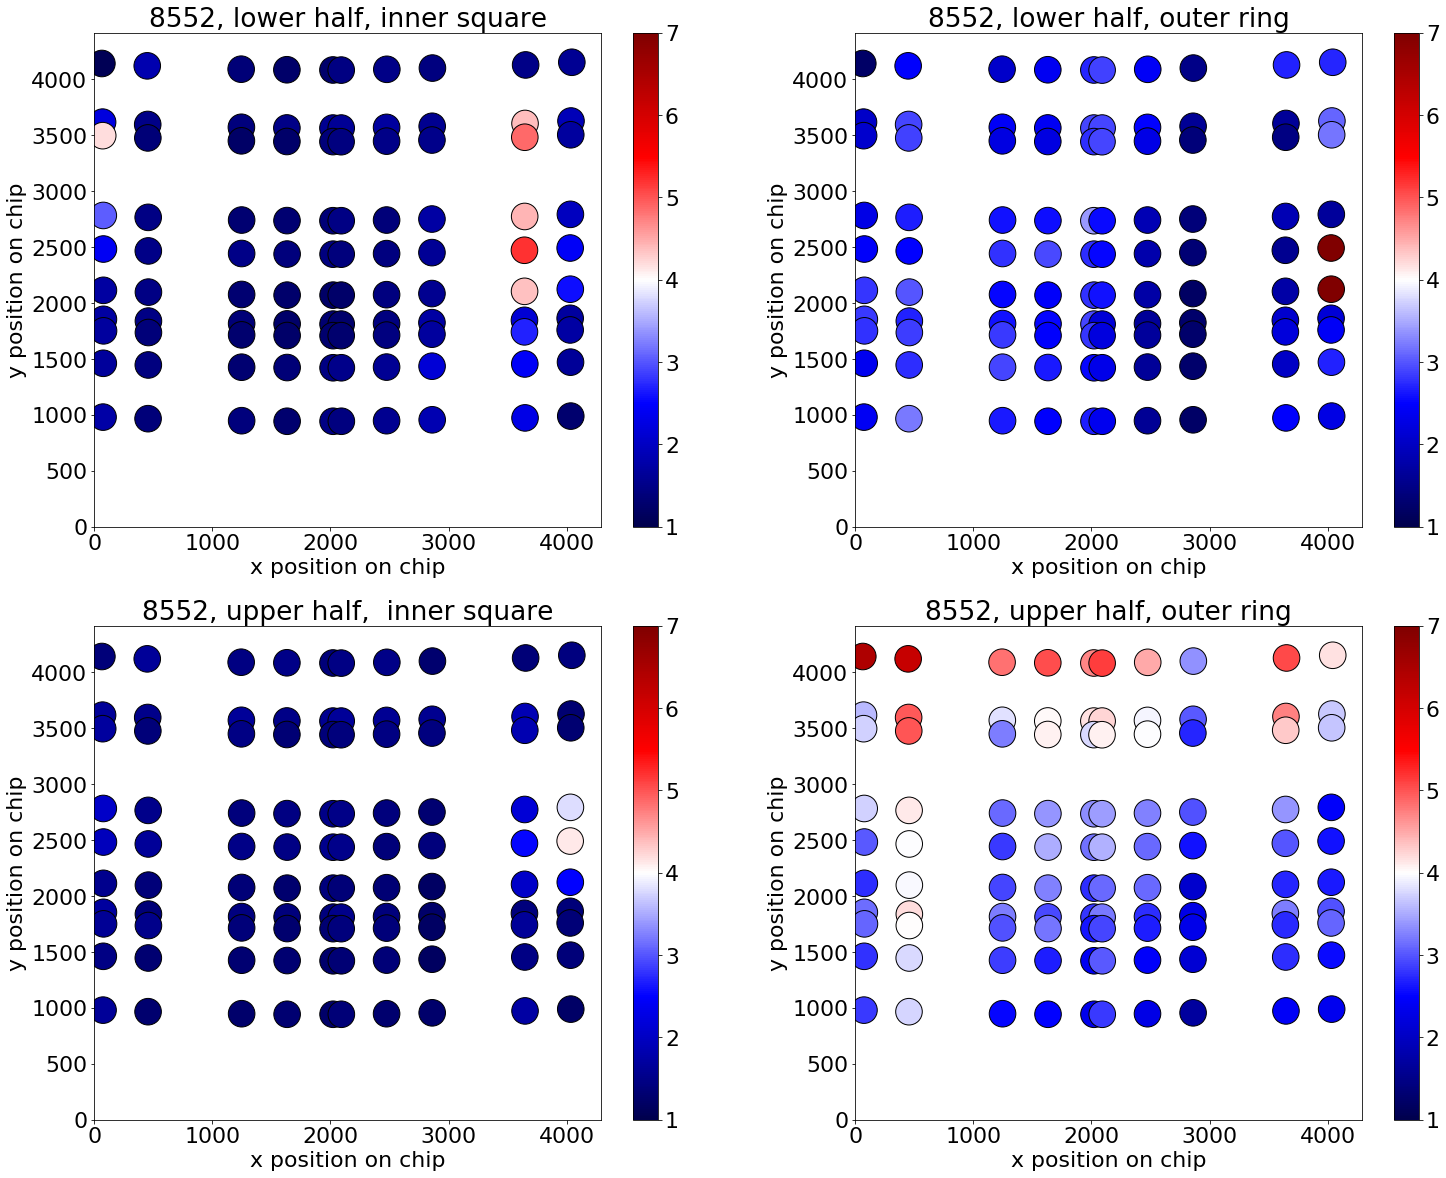

In [202]:
max_colors=7
min_colors=1

plt.figure(figsize=(25,20))
plt.subplot(221)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8552[:,1]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8552, lower half, inner square')


plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')

plt.colorbar()


plt.subplot(222)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8552[:,0]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8552, lower half, outer ring')
plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')

plt.colorbar()

plt.subplot(223)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8552[:,2]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8552, upper half,  inner square')


plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')

plt.colorbar()

plt.subplot(224)
x=single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[3]].ravel()
y=4294-single_number_for_single_pos_full[single_number_for_single_pos_full_selection[:,0].astype(int)][:,[4]].ravel()
values=res8552[:,3]
colors=values.ravel()
area = np.pi * (15 * 1)**2  # 0 to 15 point radii
plt.title('8552, upper half, outer ring')
plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')

plt.colorbar()

In [105]:
obs='8552'
single_number='82'
image_index=int(single_number)
eps=5
#date='Sep19'
#date='Sep28'
date='Oct5'


obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [106]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (248, 100, 31)
minimal likelihood is: 11921.5290647
minimal chi2 reduced is: 6.61846969492


In [107]:
columns[15]

NameError: name 'columns' is not defined

In [108]:
minchain[1]=0
minchain[2]=0
minchain[3]=0
minchain[4]=0
minchain[5]=0
minchain[6]=0
minchain[7]=0
minchain[10]=0
minchain[11]=0
minchain[15]=0
minchain[16]=0
minchain[17]=0
minchain[18]=0
minchain[19]=0
minchain[20]=0.9
minchain[21]=0.0
minchain[22]=1
minchain[27]=0.4

In [109]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

NameError: name 'columns' is not defined

In [239]:
# frd
res_pupililluminated=[]
res_optPsf_cut_fiber_convolved_downsampled=[]
for i in tqdm([0.0,0.01,0.02,0.03,0.04]):
    minchain[21]=i
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)     
    model(minchain)

    pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
    optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
    res_pupililluminated.append(pupililluminated)
    res_optPsf_cut_fiber_convolved_downsampled.append(optPsf_cut_fiber_convolved_downsampled)

100%|███████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.94s/it]


In [251]:
    sci_image=res_optPsf_cut_fiber_convolved_downsampled[0]
    res=[]
    for i in range(60):
        res.append(np.mean(sci_image[:,i]))
    res=np.array(res)
    mid_position_x=int(np.mean(argrelextrema(res, np.greater)[0][np.logical_and(np.array(argrelextrema(res, np.greater)[0]>10),np.array(argrelextrema(res, np.greater)[0]<50))]))

    
    mid_position=int(list(sci_image[:,mid_position_x]).index(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)][int(len(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)])/2)]))
    
    x=range(0,mid_position+1)
    y=sci_image[:,mid_position_x][0:mid_position+1]
    yreduced05b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.6
    yreduced01b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.2
    freduced05b =UnivariateSpline(x, yreduced05b, s=0)
    freduced01b =UnivariateSpline(x, yreduced01b, s=0)
    print(freduced05b.roots())
    print(freduced01b.roots())

    x=range(mid_position,60)
    y=sci_image[:,mid_position_x][mid_position:60]
    yreduced05t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.6
    yreduced01t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.2
    freduced05t =UnivariateSpline(x, yreduced05t, s=0)
    freduced01t =UnivariateSpline(x, yreduced01t, s=0)
    print(freduced05t.roots())
    print(freduced01t.roots())

    
    plt.figure(figsize=(25,10))

    plt.subplot(121)
    plt.imshow(sci_image,norm=LogNorm(),origin='lower')
    plt.subplot(122)
    plt.plot(range(0,mid_position+1),sci_image[:,mid_position_x][0:mid_position+1],color='b')
    plt.axvline(freduced05b.roots()[0],ls='--',color='b')
    plt.axvline(freduced05b.roots()[1],ls='--',color='b')
    plt.axvline(freduced01b.roots()[0],ls=':',color='b')
    plt.axvline(freduced01b.roots()[1],ls=':',color='b')
    plt.plot(range(mid_position,60),sci_image[:,mid_position_x][mid_position:60],color='r')
    plt.axvline(freduced05t.roots()[0],ls='--',color='r')
    plt.axvline(freduced05t.roots()[1],ls='--',color='r')
    plt.axvline(freduced01t.roots()[0],ls=':',color='r')
    plt.axvline(freduced01t.roots()[1],ls=':',color='r')
    
    print(np.concatenate((np.abs(freduced05b.roots()[-2:]-freduced01b.roots()[-2:]),np.abs(freduced05t.roots()[-2:]-freduced01t.roots()[-2:]))))

[ 10.95930385  21.5050188 ]
[  9.58432644  22.86735495]
[ 38.20719544  48.77471001]
[ 36.84890146  50.13382763]
[ 1.37497741  1.36233615  1.35829399  1.35911763]


In [276]:
columns[15]

'radiometricExponent'

In [293]:
# y_fiber
res_pupililluminated=[]
res_optPsf_cut_fiber_convolved_downsampled=[]
for i in tqdm([0.0,0.4,0.7,0.9,1.4]):
    
    #frd sigma
    minchain[21]=0.08
    # y_fiber
    minchain[19]=0.2
    

   # y_ilum
    minchain[17]=0.2   
    # rad exponent
    minchain[15]=i
    
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)     
    model(minchain)

    pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
    optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
    res_pupililluminated.append(pupililluminated)
    res_optPsf_cut_fiber_convolved_downsampled.append(optPsf_cut_fiber_convolved_downsampled)

100%|███████████████████████████████████████████████████████████| 5/5 [00:41<00:00,  8.36s/it]


In [294]:
    sci_image=res_optPsf_cut_fiber_convolved_downsampled[1]

    
    res=[]
    for i in range(60):
        res.append(np.mean(sci_image[:,i]))
    res=np.array(res)
    mid_position_x=int(np.mean(argrelextrema(res, np.greater)[0][np.logical_and(np.array(argrelextrema(res, np.greater)[0]>10),np.array(argrelextrema(res, np.greater)[0]<50))]))

    
    mid_position=int(list(sci_image[:,mid_position_x]).index(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)][int(len(sci_image[:,mid_position_x][sci_image[:,mid_position_x]<(np.max(sci_image[:,mid_position_x])*0.1)])/2)]))
    
    x=range(0,mid_position+1)
    y=sci_image[:,mid_position_x][0:mid_position+1]
    yreduced05b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.6
    yreduced01b = np.array(y) - np.max(sci_image[:,mid_position_x][0:mid_position+1])*0.2
    freduced05b =UnivariateSpline(x, yreduced05b, s=0)
    freduced01b =UnivariateSpline(x, yreduced01b, s=0)
    print(freduced05b.roots())
    print(freduced01b.roots())

    x=range(mid_position,60)
    y=sci_image[:,mid_position_x][mid_position:60]
    yreduced05t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.6
    yreduced01t = np.array(y) - np.max(sci_image[:,mid_position_x][mid_position:60])*0.2
    freduced05t =UnivariateSpline(x, yreduced05t, s=0)
    freduced01t =UnivariateSpline(x, yreduced01t, s=0)
    print(freduced05t.roots())
    print(freduced01t.roots())

    
    plt.figure(figsize=(25,10))

    plt.subplot(121)
    plt.imshow(sci_image,norm=LogNorm(),origin='lower')
    plt.subplot(122)
    plt.plot(range(0,mid_position+1),sci_image[:,mid_position_x][0:mid_position+1],color='b')
    plt.axvline(freduced05b.roots()[0],ls='--',color='b')
    plt.axvline(freduced05b.roots()[1],ls='--',color='b')
    plt.axvline(freduced01b.roots()[0],ls=':',color='b')
    plt.axvline(freduced01b.roots()[1],ls=':',color='b')
    plt.plot(range(mid_position,60),sci_image[:,mid_position_x][mid_position:60],color='r')
    plt.axvline(freduced05t.roots()[0],ls='--',color='r')
    plt.axvline(freduced05t.roots()[1],ls='--',color='r')
    plt.axvline(freduced01t.roots()[0],ls=':',color='r')
    plt.axvline(freduced01t.roots()[1],ls=':',color='r')
    
    print(np.concatenate((np.abs(freduced05b.roots()[-2:]-freduced01b.roots()[-2:]),np.abs(freduced05t.roots()[-2:]-freduced01t.roots()[-2:]))))

[ 16.83730381  22.03403094]
[ 14.2017327   23.40501073]
[ 38.02848319  44.55927241]
[ 36.61349014  47.71665073]
[ 2.6355711   1.3709798   1.41499305  3.15737832]


In [296]:
plt.imshow(res_pupililluminated[4])

In [304]:
obs='8603'
i=0
single_number=str(i)
image_index=int(single_number)


sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

plt.imshow(sci_image,origin='lower')
model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)     


minchain[21]=0.02

model(minchain)

-958352.96600903978

In [305]:
%timeit model(minchain)

555 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [191]:
plt.plot(sci_image[:,mid_position_x])

In [193]:
[0,1,2][-2:]

[1, 2]

In [132]:
np.logical_and(np.array(argrelextrema(res, np.greater)[0]>10),np.array(argrelextrema(res, np.greater)[0]<50))

array([False, False, False,  True,  True], dtype=bool)

In [620]:
plt.figure(figsize=(20,10))
plt.plot(res_iapetus2[:,26])
plt.plot(res_iapetus4[:,26])
plt.plot(res_iapetus6[:,26])
plt.plot(res_iapetus8[:,26])
plt.plot(sci_image[:,26])


In [353]:
chain_Swarm1=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct10/"+'chain'+str("Oct10")+'_Single_'+str("P")+'_'+str("8555")+str("56")+str("5")+'Swarm1.npy')
likechain_Swarm1=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct10/"+'likechain'+str("Oct10")+'_Single_'+str("P")+'_'+str("8555")+str("56")+str("5")+'Swarm1.npy')

In [344]:
chain_Emcee2=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct10/"+'chain'+str("Oct10")+'_Single_'+str("P")+'_'+str("8555")+str("56")+str("5")+'Emcee2.npy')
likechain_Emcee2=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct10/"+'likechain'+str("Oct10")+'_Single_'+str("P")+'_'+str("8555")+str("56")+str("5")+'Emcee2.npy')

In [345]:
columns

['z4',
 'z5',
 'z6',
 'z7',
 'z8',
 'z9',
 'z10',
 'z11',
 'hscFrac',
 'strutFrac',
 'dxFocal',
 'dyFocal',
 'slitFrac',
 'slitFrac_dy',
 'radiometricEffect',
 'radiometricExponent',
 'x_ilum',
 'y_ilum',
 'x_fiber',
 'y_fiber',
 'effective_radius_illumination',
 'frd_sigma',
 'det_vert',
 'slitHolder_frac_dx',
 'grating_lines',
 'scattering_radius',
 'scattering_slope',
 'scattering_amplitude',
 'pixel_effect',
 'fiber_r',
 'flux']

In [245]:
columns[21]

'frd_sigma'

In [250]:
res=[]
for i in chain_Swarm1[:,:,21]:
    res.append(np.median(i))

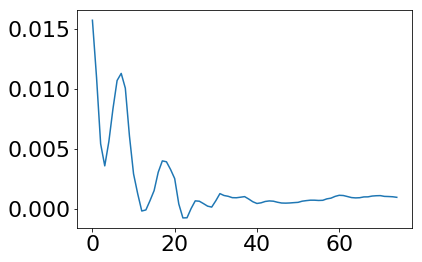

In [251]:
plt.plot(res)

In [253]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil_pre1.npy')        
pupil_first_cut=pupililluminated

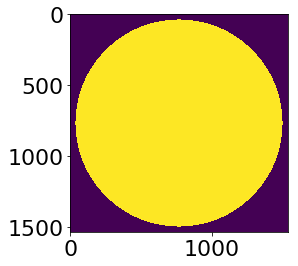

In [254]:
plt.imshow(pupil_first_cut)

In [257]:
from scipy.ndimage.filters import gaussian_filter

In [308]:
sigma=pupililluminated.shape[0]*0.0165
pupililluminated_gaussian=gaussian_filter(pupililluminated, sigma=sigma)
print(sigma)

25.344


In [309]:
plt.plot(pupililluminated_gaussian[int(1536/2)][1450:1536])
plt.plot(pupililluminated[int(1536/2)][1450:1536])
plt.axhline(0.85,ls='--')
plt.axhline(0.15,ls='--')

In [310]:
# radius of my image
print(np.sum(pupililluminated[int(1536/2)][int(1536/2):1536]))
print(len(pupililluminated_gaussian[int(1536/2)][int(1536/2):1536][pupililluminated_gaussian[int(1536/2)][int(1536/2):1536]>0.85]))
print(len(pupililluminated_gaussian[int(1536/2)][int(1536/2):1536][pupililluminated_gaussian[int(1536/2)][int(1536/2):1536]>0.15]))
width=-len(pupililluminated_gaussian[int(1536/2)][int(1536/2):1536][pupililluminated_gaussian[int(1536/2)][int(1536/2):1536]>0.85])+len(pupililluminated_gaussian[int(1536/2)][int(1536/2):1536][pupililluminated_gaussian[int(1536/2)][int(1536/2):1536]>0.15])

730.0
703
759


In [311]:
width/730

0.07671232876712329

In [312]:
60/790

0.0759493670886076

In [313]:
6.8/0.0165

412.12121212121207

In [383]:
plt.figure(figsize=(30,12))
plt.plot(res_iapetus6[:,26])
plt.plot(res_iapetus4[:,26])
plt.plot(res_iapetus2[:,26])
plt.plot(sci_image[:,26])

In [751]:
minchain[1]=0
minchain[2]=0
minchain[3]=0
minchain[4]=0
minchain[5]=0
minchain[6]=0
minchain[7]=0
minchain[8]=0.3

minchain[13]=0
minchain[14]=0

minchain[10]=0
minchain[11]=0

minchain[15]=0
minchain[18]=0
minchain[19]=0
minchain[20]=0.6
minchain[28]=0.02
minchain[27]=0.0001
minchain[21]=0.08


In [752]:
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
print(dfz22)
dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
print(dfglobal2)

          z4   z5   z6   z7   z8   z9  z10  z11
0  24.642364  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   hscFrac  strutFrac  dxFocal  dyFocal  slitFrac  slitFrac_dy  \
0      0.3   0.082237      0.0      0.0  0.056459          0.0   

   radiometricEffect  radiometricExponent   x_ilum    y_ilum  
0                0.0                  0.0 -0.00334 -0.012155  
   x_fiber  y_fiber  effective_radius_illumination  frd_sigma  det_vert  \
0      0.0      0.0                            0.6       0.08  1.027633   

   slitHolder_frac_dx  grating_lines  scattering_radius  scattering_slope  \
0            -0.22374    62074.51635          15.903933          2.196222   

   scattering_amplitude  pixel_effect   fiber_r      flux  
0                0.0001          0.02  1.893951  0.987647  


In [753]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)
#model(allparameters_proposal)

106.4


-23224065.358351942

In [754]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')          

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

In [755]:
pupililluminated8=pupililluminated
res_iapetus8=res_iapetus

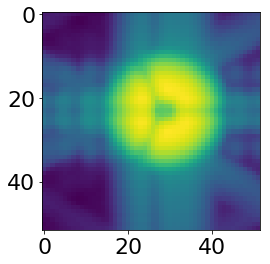

In [756]:
plt.imshow(res_iapetus8,norm=LogNorm())

In [760]:
plt.figure(figsize=(30,12))
plt.plot(np.log10(res_iapetus2[:,26]),color='orange',label='frd=8 mrad')
plt.plot(np.log10(res_iapetus4[:,26]),color='red',label='frd=16 mrad')
plt.plot(np.log10(res_iapetus6[:,26]),color='brown',label='frd=24 mrad')
plt.plot(np.log10(res_iapetus8[:,26]),color='black',label='frd=32 mrad')
plt.legend()

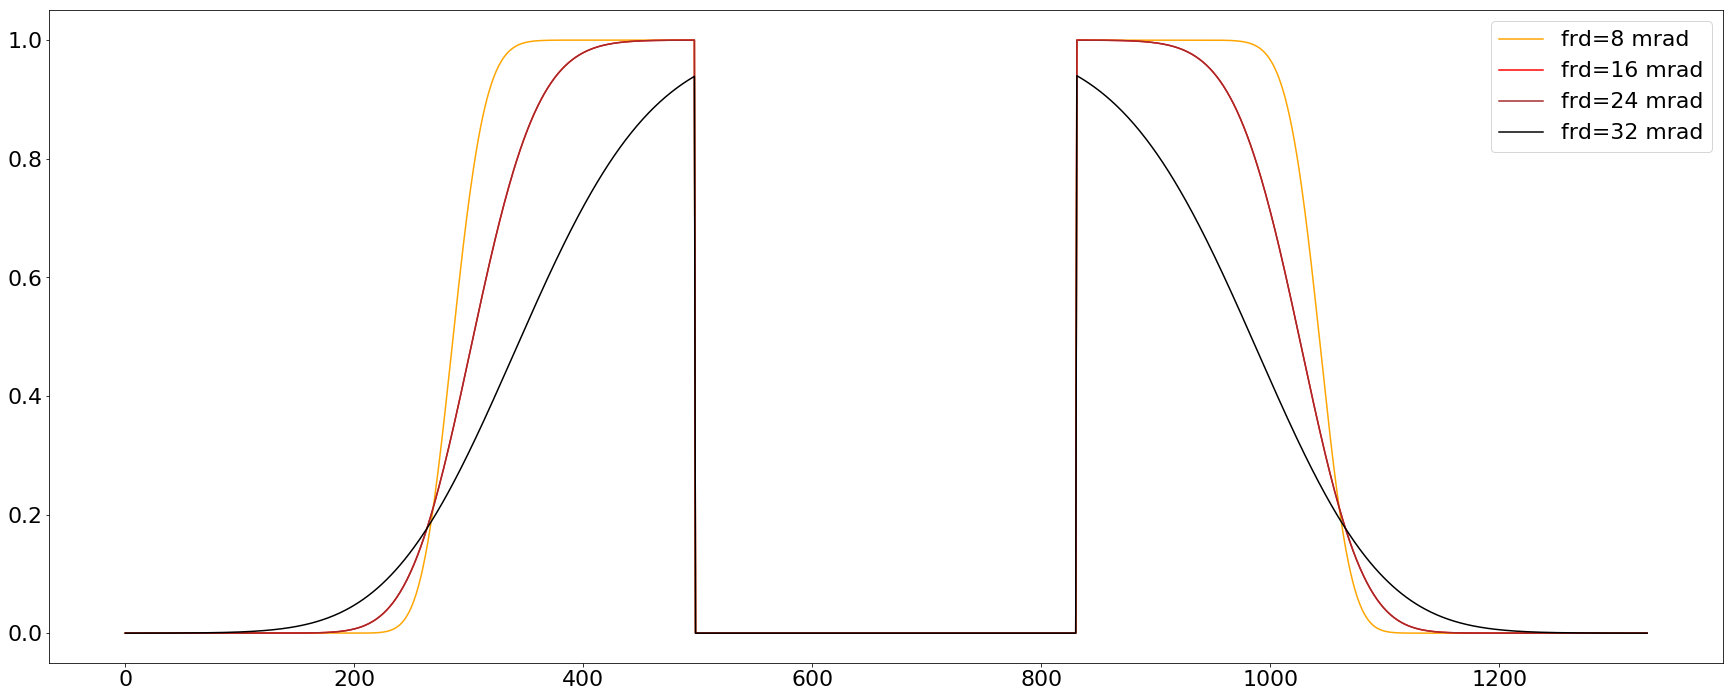

In [759]:
plt.figure(figsize=(30,12))
plt.plot(pupililluminated2[:,600],color='orange',label='frd=8 mrad')
plt.plot(pupililluminated4[:,600],color='red',label='frd=16 mrad')
plt.plot(pupililluminated6[:,600],color='brown',label='frd=24 mrad')
plt.plot(pupililluminated8[:,600],color='black',label='frd=32 mrad')
plt.legend()

# FRD experiment

In [908]:
columns[27]

'scattering_amplitude'

In [809]:
obs='8603'
single_number='55'
image_index=int(single_number)
eps=5
#date='Sep27'
date='Oct12'

obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs=='8600':
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned_Dithered.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked_Dithered.npy')
else:       
    sci_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/sci"+str(obs)+str(single_number)+'Stacked_Cleaned.npy')
    var_image=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerAug15/var"+str(obs)+str(single_number)+'Stacked.npy')

In [920]:
minchain[18]=0
minchain[19]=0
minchain[27]=0.0001
print(columns[21])
minchain[21]=0.0125*3

frd_sigma


In [921]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1)   
    
model(minchain)

-3817.7956574956556

In [922]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')

wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')          

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

In [923]:
pupililluminated3=pupililluminated
res_iapetus3=res_iapetus

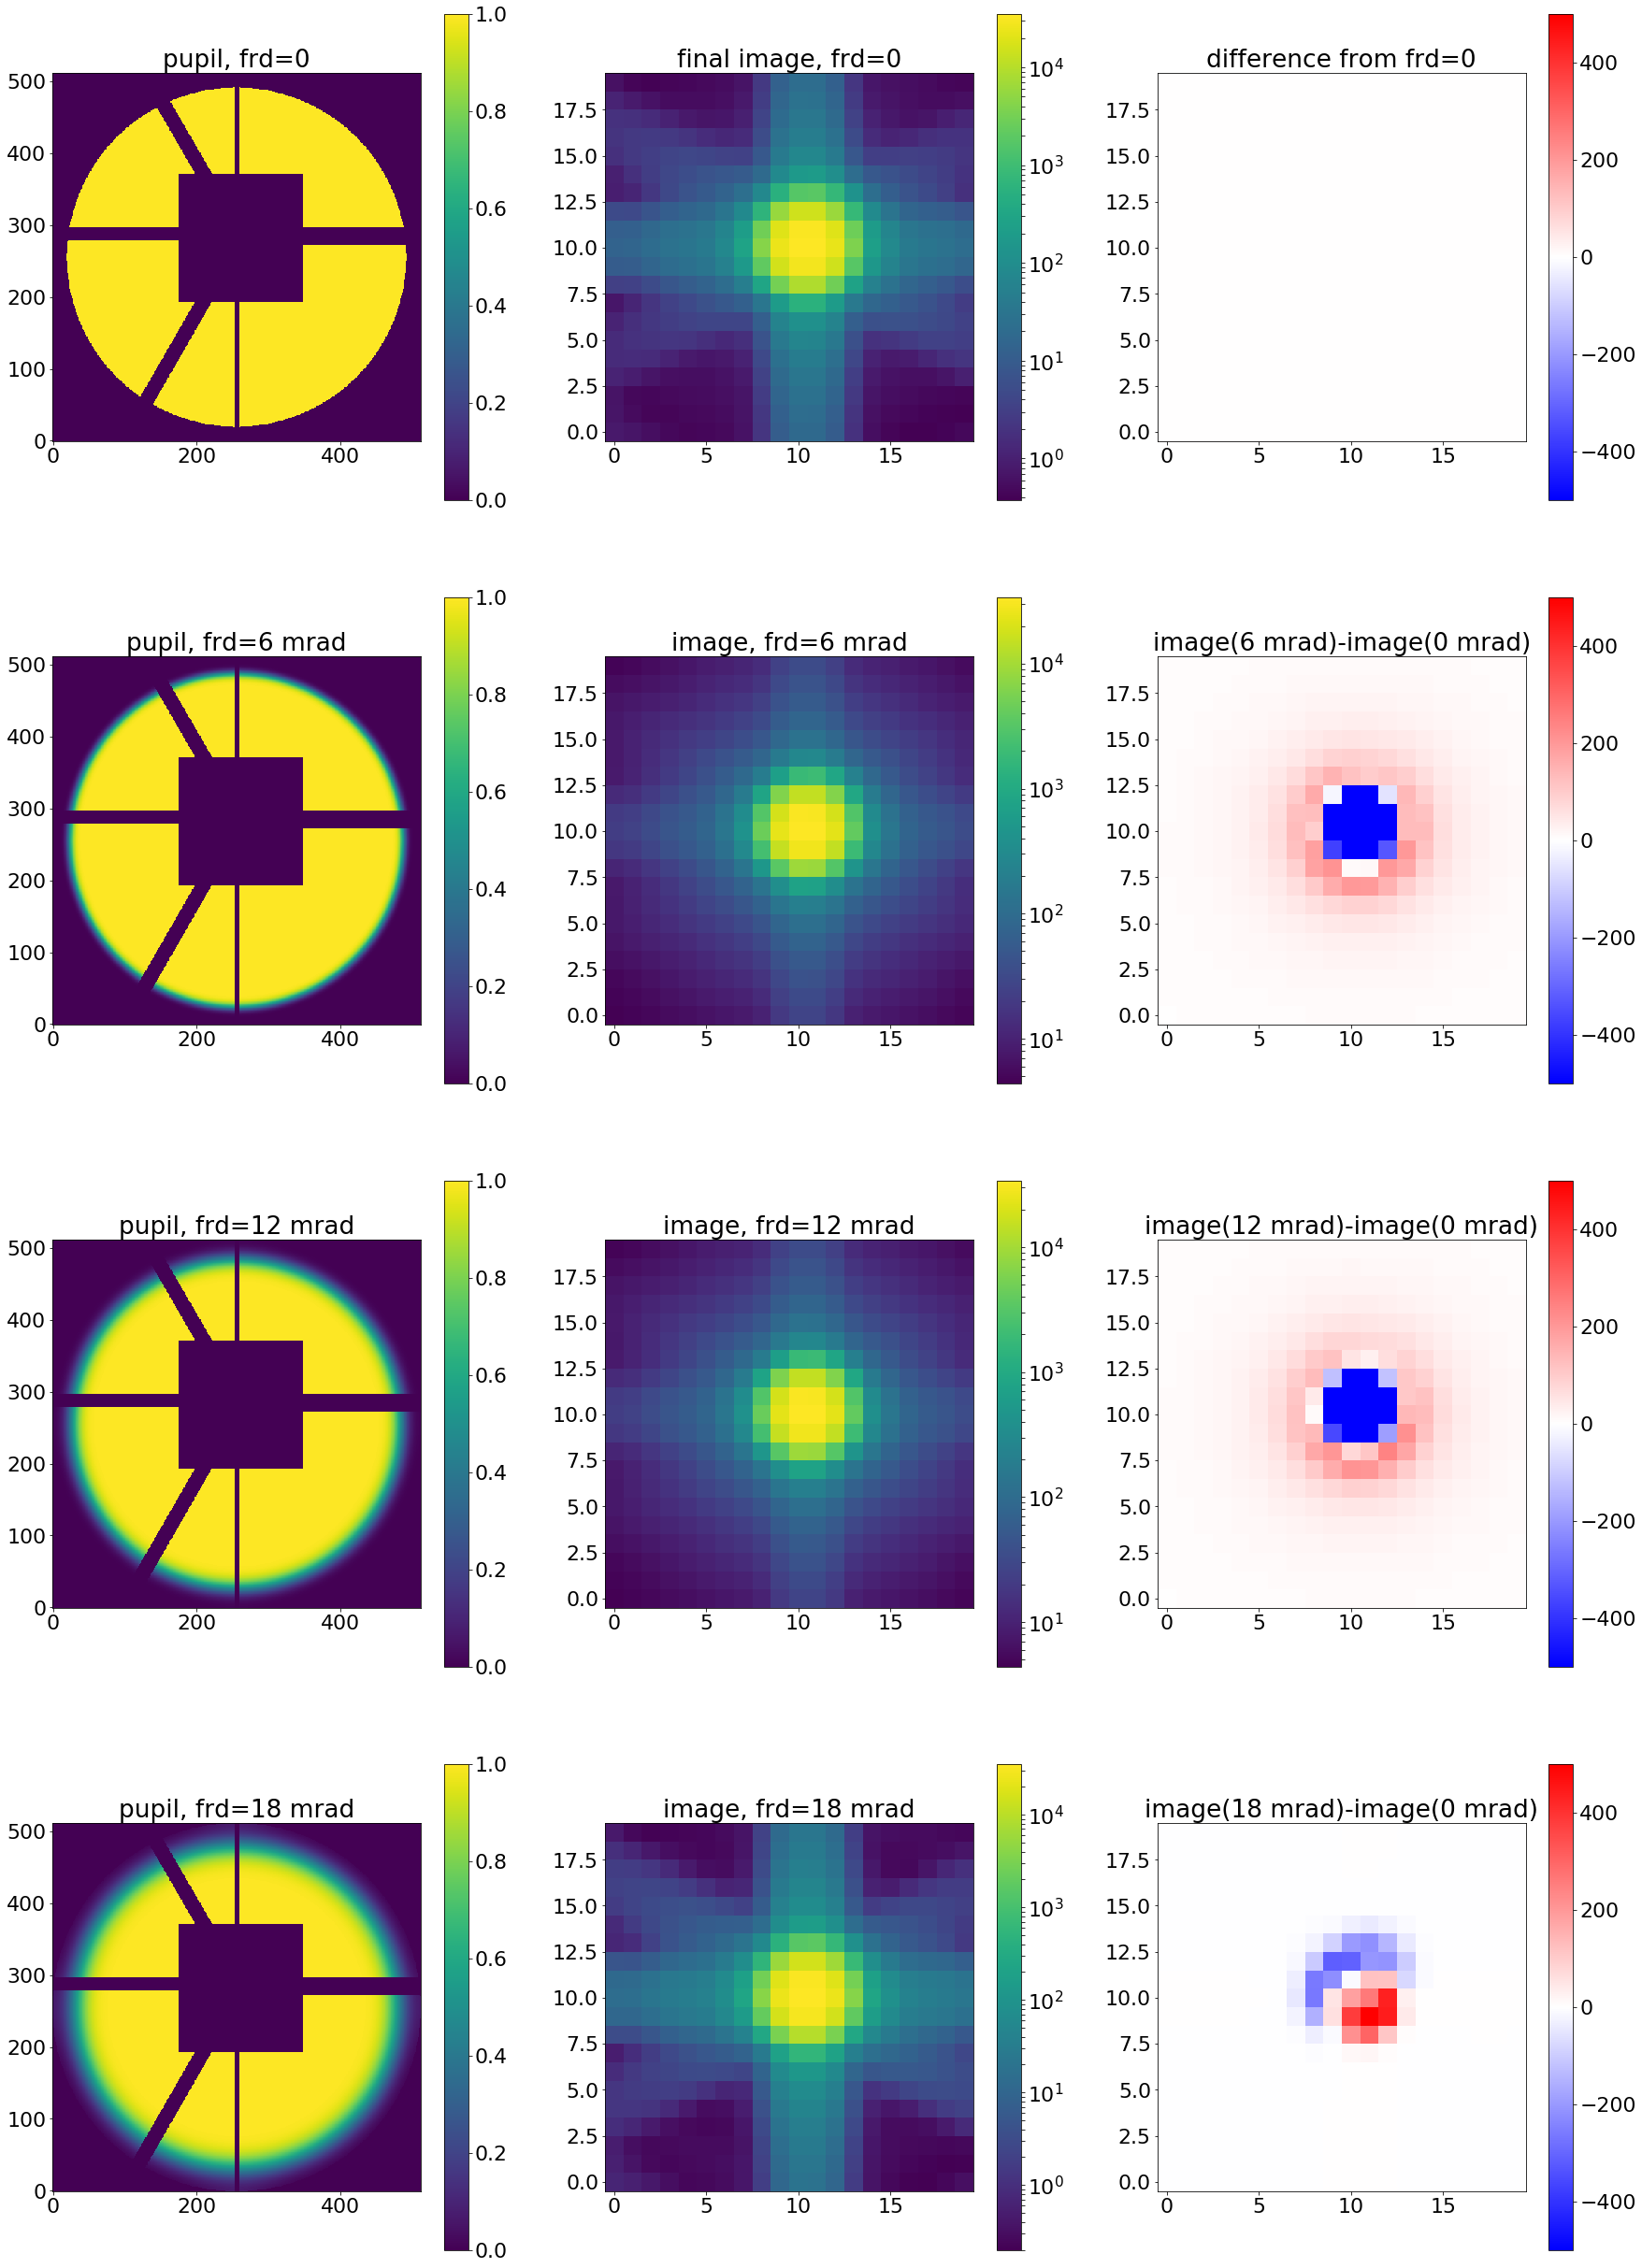

In [924]:
plt.figure(figsize=(30,44))
plt.subplot(431)
plt.imshow(pupililluminated0,origin='lower')
plt.title('pupil, frd=0')
plt.colorbar()
plt.subplot(432)
plt.imshow(res_iapetus0,origin='lower',norm=LogNorm())
plt.title('final image, frd=0')
plt.colorbar()
plt.subplot(433)
plt.imshow(res_iapetus0-res_iapetus0,origin='lower',cmap='bwr',vmax=500,vmin=-500)
plt.title('difference from frd=0')
plt.colorbar()

plt.subplot(434)
plt.imshow(pupililluminated1,origin='lower')
plt.title('pupil, frd=6 mrad')
plt.colorbar()
plt.subplot(435)
plt.imshow(res_iapetus1,origin='lower',norm=LogNorm())
plt.title('image, frd=6 mrad')
plt.colorbar()
plt.subplot(436)
plt.imshow(res_iapetus1-res_iapetus0,origin='lower',cmap='bwr',vmax=500,vmin=-500)
plt.title('image(6 mrad)-image(0 mrad)')
plt.colorbar()

plt.subplot(437)
plt.imshow(pupililluminated2,origin='lower')
plt.title('pupil, frd=12 mrad')
plt.colorbar()
plt.subplot(438)
plt.imshow(res_iapetus2,origin='lower',norm=LogNorm())
plt.title('image, frd=12 mrad')
plt.colorbar()
plt.subplot(439)
plt.imshow(res_iapetus2-res_iapetus0,origin='lower',cmap='bwr',vmax=500,vmin=-500)
plt.title('image(12 mrad)-image(0 mrad)')
plt.colorbar()

plt.subplot(4,3,10)
plt.imshow(pupililluminated3,origin='lower')
plt.title('pupil, frd=18 mrad')
plt.colorbar()
plt.subplot(4,3,11)
plt.imshow(res_iapetus3,origin='lower',norm=LogNorm())
plt.title('image, frd=18 mrad')
plt.colorbar()
plt.subplot(4,3,12)
plt.imshow(res_iapetus3-res_iapetus0,origin='lower',cmap='bwr',vmax=500,vmin=-500)
plt.title('image(18 mrad)-image(0 mrad)')
plt.colorbar()

In [881]:
np.max(res_iapetus3-res_iapetus0)/

516.87660032843633

In [904]:
plt.imshow((res_iapetus3-res_iapetus0)/np.sqrt(var_image),origin='lower',cmap='bwr',vmax=3,vmin=-3)
plt.colorbar()

# Speed up

In [114]:
pupil_pre1=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil_pre1.npy') 
pupil_pre2=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil_pre2.npy') 

aperu_manual=[]
for i in range(len(pupil_pre1)):
    aperu_manual.append(np.linspace(-1,1,len(pupil_pre1), endpoint=True))
    #aperu_manual.append(np.linspace(-diam_sic*(size_of_ilum_in_units_of_radius/1),diam_sic*(size_of_ilum_in_units_of_radius/1),len(r_ilum), endpoint=True))

single_element=np.linspace(-1,1,len(pupil_pre1), endpoint=True)
u_manual=np.tile(single_element,(len(single_element),1))    
    
u_manual=np.array(aperu_manual)
v_manual=np.transpose(aperu_manual)  

In [91]:
single_element=np.linspace(-1,1,len(pupil_pre1), endpoint=True)
u_manual=np.tile(single_element,(len(single_element),1))
center_distance=np.sqrt(u_manual**2+v_manual**2)

In [92]:
plt.imshow(center_distance)

In [86]:
res=[]
for i in np.linspace(0,1,int(len(pupil_pre1)/2), endpoint=True):
    res.append((scipy.special.erf((-i+0.9)*100)+1)/2)
    
res=np.array(res)

In [97]:
sigma=0.001
1/2*(scipy.special.erf((-i+0.9)/sigma)+scipy.special.erf((i+0.9)/sigma))

0.0

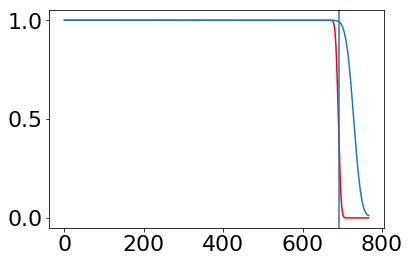

In [87]:
plt.plot(res,'r')
plt.plot(pupil_pre2[int(len(pupil_pre1)/2)][int(len(pupil_pre1)/2):])
plt.axvline(int(len(pupil_pre1)/2*0.9))

In [94]:
%timeit (scipy.special.erf((-center_distance+0.9)*100)+1)/2

47.8 ms ± 992 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
frd_sigma=0.01
sigma=2*frd_sigma
plt.imshow(1/2*(scipy.special.erf((-center_distance+0.9)/sigma)+scipy.special.erf((center_distance+0.9)/sigma)))

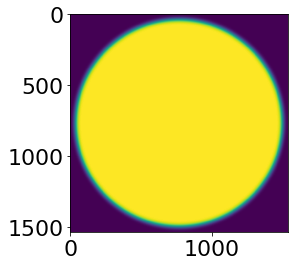

In [57]:
from scipy.ndimage.filters import gaussian_filter
plt.imshow(pupil_pre1)
frd_sigma=0.01
sigma=pupil_pre1.shape[0]*frd_sigma
pupil_pre2=gaussian_filter(pupil_pre1, sigma=sigma)
plt.imshow(pupil_pre2)

In [115]:
plt.imshow(pupil_pre2)

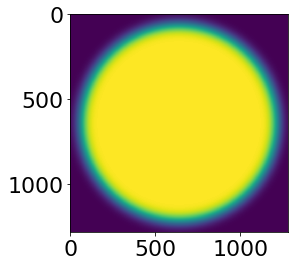

In [124]:
single_element=np.linspace(-1,1,len(pupil_pre1), endpoint=True)
u_manual=np.tile(single_element,(len(single_element),1))
v_manual=np.transpose(u_manual)  
center_distance=np.sqrt(u_manual**2+v_manual**2)

frd_sigma=0.04
sigma=2*frd_sigma
plt.imshow(1/2*(scipy.special.erf((-center_distance+0.9)/sigma)+scipy.special.erf((center_distance+0.9)/sigma)))

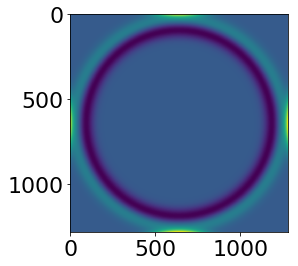

In [125]:
plt.imshow(pupil_pre2-1/2*(scipy.special.erf((-center_distance+0.9)/sigma)+scipy.special.erf((center_distance+0.9)/sigma)))

# Scattering 

In [197]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_radius','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  




sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))

allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.0,0.0,0.07,-0.2,
                                 0.7,1,-0.0,0.00,
                                 0.2,0.1,0.90,
                                 0.1,1,0.28,
                                 50000,20,2.5,0.01,
                                 0.47,1.85,1.0])

model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

-3955.9506538


In [198]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

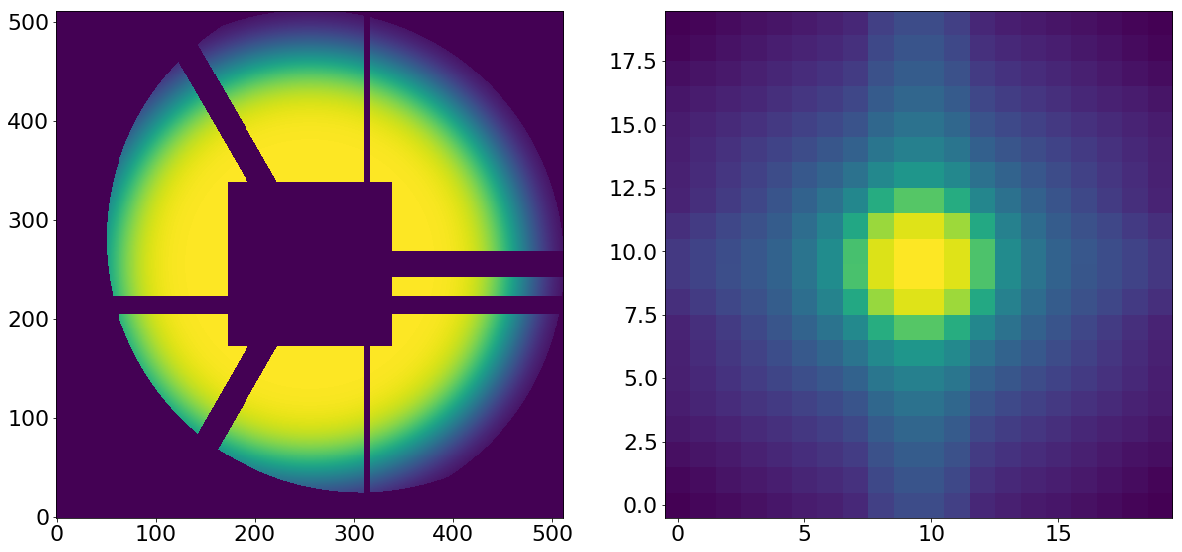

In [199]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

In [200]:
scattered_light_kernel=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light_kernel.npy')

In [189]:
scattered_light=np.load(TESTING_FINAL_IMAGES_FOLDER+'scattered_light.npy')

-3.0


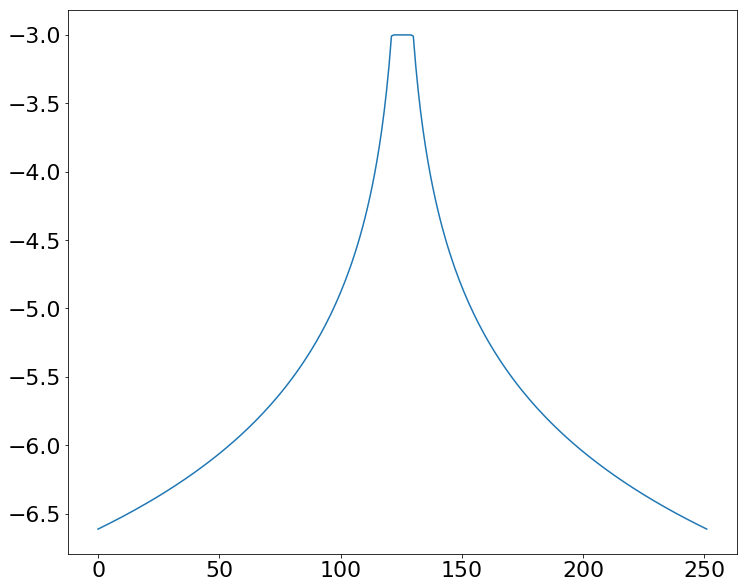

In [196]:
print(np.max(np.log10(scattered_light_kernel[126])))
plt.plot(np.log10(scattered_light_kernel[126]))

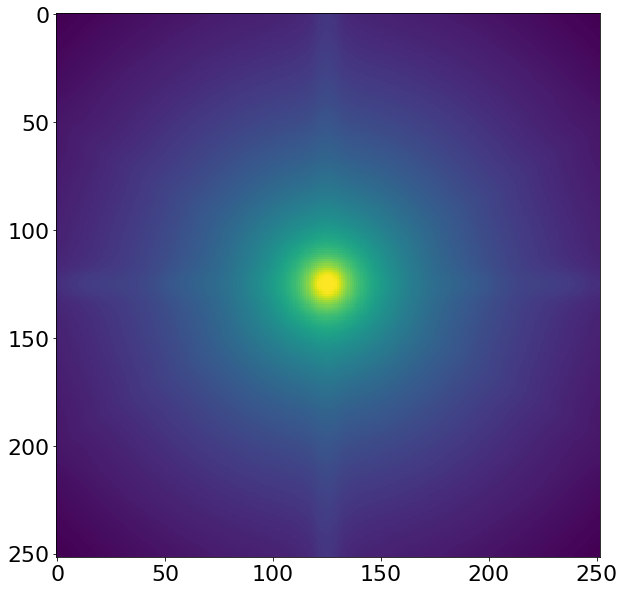

In [191]:
plt.imshow(scattered_light,norm=LogNorm())